In [1]:
# PTT title generator from content base on seq2seq model.
import pandas as pd
import numpy as np
import csv
import os
import types 

#Initialize for files name and path.
base_dir = 'E:/Raw data/PTT'
totalboard_name = 'BG-CC-MV-SX-TJ-WT'
board_name = ['Boy-Girl','C_Chat','movie','sex','Tech_job','WomenTalk']
board_dict_index = {'Boy-Girl':0,'C_Chat':1,'movie':2,'sex':3,'Tech_job':4,'WomenTalk':5}

build_vocab = True
label_newnum = len(board_name)
max_word_length = 250+2
min_word_length = 100
max_push_length = 100+2
words_limit = 30000
filters_char='"#()*-/;[\]^_`{|}~\t\n'
#filters_char='ˊˋ#*×/\\^_`|＼﹨｜〝〞‵′＊／－-≦≧＿＃⌒‿．§◎˙※ㄧ↔│ꄊ✂☁☛✈♥○●☆★◇◆□■▽▼△▲㊣⊙⊕ˍ…﹌﹋﹎﹍﹉﹊‥–↑↓←→↖↗↙↘∥∕℅≒≡∩∪∞￣＿◤◥◣◢∵∴〒⊥∠⊿┼┴┬┤├▔─│▕┌┐└┘╭╮╰╯═╞╪╡╔╦╗╠╬╣╚╩╝╒╤╕╘╧╛╓╥╖╟╫╢╙╨╜║▓░▒╱╲╳▁━▶▁▂▃▄▅▆▇█▉▊▋▋▌▍▎▏▐▔■▁▔'

SOS_id = '<sos>' #解碼器端的句子起始標識符。
EOS_id = '<eos>' #解碼器端的句子結束標識符。
UNK_id = '<unk>' #低頻詞或者一些未遇到過的詞等。
PAD_id = '<pad>' #補全字符。

new_content_dir = []
new_push_dir = []
totalboard_dir = os.path.join(base_dir, totalboard_name)
if not os.path.exists(totalboard_dir):
    os.makedirs(totalboard_dir)
for name_ind in range(len(board_name)):
    # New data path
    new_content_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_content'))
    if not os.path.exists(new_content_dir[name_ind]):
        os.makedirs(new_content_dir[name_ind])
    new_push_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_push'))
    if not os.path.exists(new_push_dir[name_ind]):
        os.makedirs(new_push_dir[name_ind])

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import jieba
import json

# Import dictionary fron jieba and PTT.
jieba.set_dictionary('C:/Users/User/Anaconda3/Lib/site-packages/jieba/dict.txt.big')
jieba.load_userdict('C:/Users/User/Anaconda3/Lib/site-packages/jieba/userdict.txt')

text_content = []
text_push = []

# Load PTT content and information.
dfs_total = pd.read_csv(os.path.join(totalboard_dir, totalboard_name + '.csv'))
len_total = len(dfs_total)

for dfs_index in range(len_total):
    read_index = int(dfs_total.iloc[dfs_index, 0])
    type_name = str(dfs_total.iloc[dfs_index, 1])
    word_length = int(dfs_total.iloc[dfs_index, 5])
    push_length = int(dfs_total.iloc[dfs_index, 6])
    title_name = str(dfs_total.iloc[dfs_index, 9])
    this_board_name = str(dfs_total.iloc[dfs_index, 10])
    
    # Add start and end character for content.
    text = SOS_id + ' '
    with open(os.path.join(new_content_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            for row in rows:
                # Read content and remove empty.
                text = text + row
        else:
            text = text + ' ' + EOS_id
    
    # Add start and end character for push.
    with open(os.path.join(new_push_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            # Read content and remove empty.
            for row in rows:
                # load only the first push text.
                push = SOS_id + ' ' + row + ' ' + EOS_id
                text_push.append(push)
    text_content.append(text)
    
if build_vocab:
    from keras.preprocessing.text import Tokenizer
    # Build vocabulary and convert content to sequence by Keras tool.
    tokenizer = Tokenizer(num_words=words_limit, 
                          filters=filters_char,
                          lower=True,
                          split=" ")
                          #oov_token=UNK_word)
    tokenizer.fit_on_texts(text_content+text_push)
    vocab_sort = tokenizer.word_index
    vocab_counts = tokenizer.word_counts
    vocab_docs = tokenizer.word_docs

    print('Vocabulary size:', len(vocab_sort))
    vocab = {}
    vocab_reverse = {}
    vocab_keys = list(vocab_sort.keys())
    for vocab_word in vocab_keys:
        vocab_index = vocab_sort[vocab_word]
        if vocab_index <= words_limit+2:
            vocab_reverse[vocab_index] = vocab_keys[vocab_index-1]
            vocab[vocab_keys[vocab_index-1]] = vocab_index
            if vocab_index % 1000 == 0 or vocab_index < 100:
                print(vocab[vocab_word], vocab_word, vocab_reverse[vocab_index], 
                      vocab_counts[vocab_word], vocab_docs[vocab_word])
    else:
        #vocab[SOS_id] = words_limit + 1
        #vocab_reverse[words_limit + 1] = SOS_id
        #vocab[EOS_id] = words_limit + 2
        #vocab_reverse[words_limit + 2] = EOS_id
        vocab[UNK_id] = words_limit + 3
        vocab_reverse[words_limit + 3] = UNK_id

    # Save vocabulary information.
    with open(os.path.join(totalboard_dir, 'vocab_sort.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_sort))
    with open(os.path.join(totalboard_dir, 'vocab_counts.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_counts))
    with open(os.path.join(totalboard_dir, 'vocab_docs.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_docs))
    with open(os.path.join(totalboard_dir, 'vocab.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab))
    with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'w', encoding='utf-8-sig') as f_text:
        f_text.write(str(vocab_reverse))
else:
    # Load vocabulary information.
    with open(os.path.join(totalboard_dir, 'vocab.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab = eval(f_text.read())
    with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_reverse = eval(f_text.read())
    with open(os.path.join(totalboard_dir, 'vocab_sort.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_sort = eval(f_text.read())
    #with open(os.path.join(totalboard_dir, 'vocab_counts.json') , 'r', encoding='utf-8-sig') as f_text:
        #vocab_counts = eval(f_text.read())
    with open(os.path.join(totalboard_dir, 'vocab_docs.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_docs = eval(f_text.read())
    vocab_size = len(vocab)

    # Build vocabulary and convert content to sequence by Keras tool.
    # Convert texts list to sequences list.
    def texts_to_sequences(text_list):
        sequences_list = []
        for text in text_list:
            words = text.split(' ')
            sequence = []
            for word in words:
                if filters_char.find(word)>=0:
                    continue
                elif word in vocab:
                    sequence.append(vocab[word])
                else:
                    sequence.append(vocab[UNK_id])
            sequences_list.append(sequence)
        return sequences_list

# 將單字轉換成字庫的索引值
if build_vocab:
    total_content_word_ids = tokenizer.texts_to_sequences(text_content+text_push)
else:
    total_content_word_ids = texts_to_sequences(text_content+text_push)
total_content_size = [len(word_ids) for word_ids in total_content_word_ids]

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Building prefix dict from C:\Users\User\Anaconda3\Lib\site-packages\jieba\dict.txt.big ...
Dumping model to file cache C:\Users\User\AppData\Local\Temp\jieba.ufa6ae29b0cbce8b45e006c7fa30eaaf8.cache
Loading model cost 1.335 seconds.
Prefix dict has been built succesfully.


Vocabulary size: 441035
1 <sos> <sos> 1506497 1506497
2 <eos> <eos> 1506497 1506497
3 . . 908712 271897
4 的 的 800583 504881
5 , , 703008 348633
6 是 是 366564 293198
7 我 我 349251 259420
8 了 了 309852 259993
9 ' ' 239430 103912
10 你 你 222123 175475
11 ? ? 220762 176965
12 有 有 218561 182774
13 就 就 207726 182331
14 都 都 199092 174859
15 也 也 174970 153132
16 不 不 158586 139858
17 在 在 137875 116890
18 很 很 130847 115145
19 會 會 127763 112276
20 ! ! 117123 97417
21 嗎 嗎 116168 108201
22 好 好 108314 100447
23 要 要 107149 96017
24 看 看 105601 92116
25 跟 跟 104109 92794
26 吧 吧 95152 92702
27 啊 啊 94385 89339
28 他 他 93530 69971
29 說 說 90190 79056
30 人 人 87441 77070
31 可以 可以 84679 77742
32 沒 沒 83049 77180
33 覺得 覺得 76649 70244
34 去 去 74636 66957
35 想 想 70038 63091
36 被 被 66612 60129
37 真的 真的 66543 62525
38 自己 自己 63738 55446
39 什麼 什麼 62803 57320
40 不是 不是 61690 58887
41 就是 就是 60328 56400
42 她 她 59368 41182
43 但 但 59357 54388
44 到 到 57011 52855
45 知道 知道 53027 48341
46 還是 還是 50558 47137
47 不會 不會 49926 47556
48 沒有 

In [26]:
print('Vocabulary size: ', len(vocab))

skip_window = 2 # How many words to consider left and right.
num_skips = 2*skip_window # How many times to reuse an input to generate a context.
sample_threshold = 0.0002

sum_content_size = sum(total_content_size)
print('Sum over all context size: ',sum_content_size)

# Set sampling rate for word using frequency.
def sampling_rate(sample_num, total_num, sample_threshold):
    z_rate = sample_num/total_num/sample_threshold
    return min((np.sqrt(z_rate) + 1.0)/z_rate, 1.0)

sum_vocab_counts = 0
unk_count = 0
for vocab_word in vocab_sort:
    vocab_index = vocab_sort[vocab_word]
    sum_vocab_counts += vocab_counts[vocab_word]
    if vocab_index > words_limit+2:
        unk_count += vocab_counts[vocab_word]
print('Sum over all vocabulary counts: ',sum_vocab_counts)

# Build sampling rate dict for vocabulary.
vocab_rate = {}
for vocab_word in vocab:
    vocab_index = vocab[vocab_word]
    if vocab_index <= words_limit+2:
        vocab_rate[vocab_index] = sampling_rate(vocab_counts[vocab_word], 
                                        sum_vocab_counts, sample_threshold)
    else:
        assert vocab_word == UNK_id
        vocab_rate[vocab_index] = sampling_rate(unk_count, 
                             sum_vocab_counts, sample_threshold)
        break

# Convert text content to context inputs and labels array.
def generate_ngram(content_ids, content_size, skip_window):
    inputs = np.ndarray(shape=(content_size), dtype=np.int32)
    labels = np.ndarray(shape=(content_size, skip_window*2), dtype=np.int32)
    for i in range(content_size):
        for j in range(skip_window):
            if i-j>0:
                labels[i, j*2] = content_ids[i-j-1]
            else:
                labels[i, j*2] = vocab[SOS_id]
            if i+j<content_size-1:
                labels[i, j*2+1] = content_ids[i+j+1]
            else:
                labels[i, j*2+1] = vocab[EOS_id]
    return content_ids, labels

# Build all of context inputs and labels by array.
total_inputs = np.ndarray(shape=(sum_content_size), dtype=np.int32)
total_labels = np.ndarray(shape=(sum_content_size, skip_window*2), dtype=np.int32)
context_index = 0
for word_ids, word_size in zip(total_content_word_ids, total_content_size):
    inputs, labels = generate_ngram(word_ids, word_size, skip_window)
    total_inputs[context_index:context_index+word_size] = inputs
    total_labels[context_index:context_index+word_size,:] = labels
    context_index += word_size
else:
    assert context_index == sum_content_size

# If the word id was out of vocabulary, reset id to UNK_id.
np.minimum(total_inputs, words_limit + 3, total_inputs)
np.minimum(total_labels, words_limit + 3, total_labels)

Vocabulary size:  30003
Sum over all context size:  23488233
Sum over all vocabulary counts:  24962176


array([[   1,    3,    1,   92],
       [   1,   92,    1, 3394],
       [   3, 3394,    1, 3279],
       ...,
       [   8,  130,  594,    2],
       [  21,    2,    8,    2],
       [ 130,    2,   21,    2]])


epoch1
Iteration  10363  ( 10.0 %) Train mean loss:  24.736969  ( std:  13.730268 ) ; run time:  32 [s]
Iteration  20733  ( 20.0 %) Train mean loss:  17.774693  ( std:  12.71022 ) ; run time:  62 [s]
Iteration  31104  ( 30.0 %) Train mean loss:  14.254529  ( std:  11.760594 ) ; run time:  93 [s]
Iteration  41482  ( 40.0 %) Train mean loss:  12.09495  ( std:  10.952325 ) ; run time:  124 [s]
Iteration  51849  ( 50.0 %) Train mean loss:  10.633138  ( std:  10.272022 ) ; run time:  154 [s]
Iteration  62229  ( 60.0 %) Train mean loss:  9.579506  ( std:  9.69119 ) ; run time:  186 [s]
Iteration  72603  ( 70.0 %) Train mean loss:  8.784377  ( std:  9.192399 ) ; run time:  217 [s]
Iteration  82985  ( 80.0 %) Train mean loss:  8.168463  ( std:  8.75718 ) ; run time:  247 [s]
Iteration  93351  ( 90.0 %) Train mean loss:  7.6800838  ( std:  8.375051 ) ; run time:  278 [s]
Iteration  103722  ( 100.0 %) Train mean loss:  7.2827806  ( std:  8.036346 ) ; run time:  309 [s]
Save best score!!  7.2827

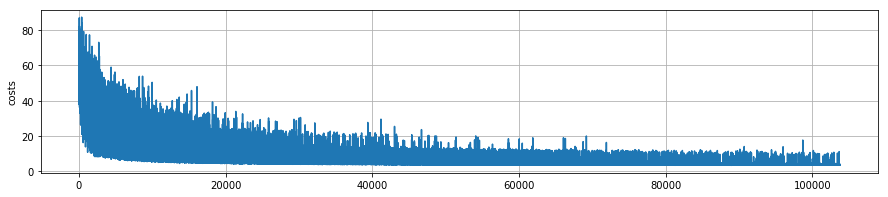

Nearest to <sos>: 跟, jptt, 作祟, 我, ,, my, 講清楚, 樓上, 罩杯, 自學,
Nearest to 我: 以前, 偉人, 哪個, <sos>, 人格, 達人, 扣錢, 我們, 國中, 擴散,
Nearest to 台灣: 雷神, 三人, 可恥, 李大仁, 啊我, 38, 自信, 集, 號, 八樓,
Nearest to 工作: 價位, 拔牙, 行員, 會場, 射出去, 六樓, 第一天, 兩粒, 手掌, 15,
Nearest to 喜歡: 說不過去, 肢體, 這張, 往往, 鞋子, 再度, 我常, 成龍, 河, 題材,
Nearest to 可以: 海關, 汽油, 插隊, 造福, 天蠍, 住院, 小吃, 特賣, 看得起, 加油,
Nearest to 約: atm, 窮, 表妹, 要花, 我試, 的你, 接觸, 毒龍, 開刀, 滅團,
Nearest to 電影: 再度, 小雞, 使出, 蘇格拉底, 還用說, 不順, 親愛, 網, 見諒, 廠務,
Nearest to 時間: 自盡, 小護士, 無可, 開車, 亮點, 的但, 上菜, 去過, 降, 達斯,
Nearest to 滿足: 小於, 基金會, 矯正, 呷, 自律, 描述, 羽絨, 沒紅, 精神分裂, 沒落,
Nearest to 閃光: 過戶, sense, 稱為, 新車, 胖次, 射完, 吸引, 爆點, jj, 卡費,
Nearest to <eos>: xd, @, 嗎, ?, ', !, =, xddd, jptt, qq,

epoch2
Iteration  10371  ( 10.0 %) Train mean loss:  3.6578467  ( std:  0.46786073 ) ; run time:  32 [s]
Iteration  20743  ( 20.0 %) Train mean loss:  3.6439345  ( std:  0.4222588 ) ; run time:  65 [s]
Iteration  31107  ( 30.0 %) Train mean loss:  3.6328151  ( std:  0.3871576 ) ; run time:  96 [s]
Iteration  41471  ( 40.0 

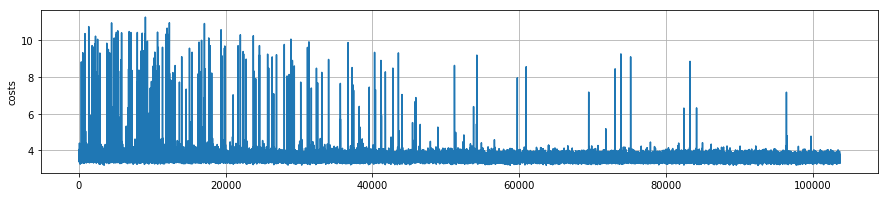

Nearest to <sos>: 跟, ,, jptt, my, 樓上, 原, 我, 是, 請問, 也,
Nearest to 我: 你, 他, 以前, 妳, <sos>, 我們, 偉人, 人格, 他們, 國中,
Nearest to 台灣: 雷神, 可恥, 三人, 啊我, 先請, 夜深, 八樓, 星期三, 棄之可惜, 台積,
Nearest to 工作: 價位, 會場, 拔牙, 行員, 第一天, 公司, 射出去, 兩粒, 訂位, 落榜,
Nearest to 喜歡: 說不過去, 討厭, 想要, 這張, 巧虎, 井底之蛙, 肢體, 再度, 人真, 我常,
Nearest to 可以: 要, 海關, 建議, 天蠍, 左手, 特賣, 説, 汽油, 小吃, ?有,
Nearest to 約: atm, 窮, 要花, 表妹, 銷魂, 我試, 990, 毒龍, 講述, 的你,
Nearest to 電影: 再度, 小雞, 蘇格拉底, 親愛, 見諒, 圖王, 網, 廠務, 還用說, 所有,
Nearest to 時間: 自盡, 開車, 上菜, 無可, 的但, 小護士, 亮點, ?沒, 墊高, 去過,
Nearest to 滿足: 小於, 基金會, 矯正, 呷, 自律, 描述, 喜事, 精神分裂, 沒紅, 羽絨,
Nearest to 閃光: 過戶, sense, 稱為, 新車, 射完, 卡費, 胖次, jj, 吸引, 吳淡如,
Nearest to <eos>: xd, ?, 嗎, @, !, my, sent, xddd, =, ',

epoch3
Iteration  10365  ( 10.0 %) Train mean loss:  3.5329723  ( std:  0.13574773 ) ; run time:  30 [s]
Iteration  20742  ( 20.0 %) Train mean loss:  3.530681  ( std:  0.13345768 ) ; run time:  65 [s]
Iteration  31108  ( 30.0 %) Train mean loss:  3.528522  ( std:  0.13192937 ) ; run time:  96 [s]
Iteration  41480  ( 40.0 

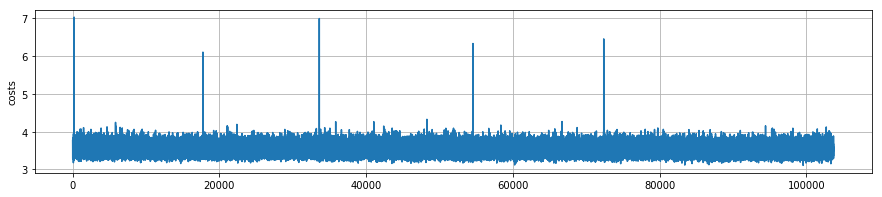

Nearest to <sos>: 跟, jptt, my, ,, 樓上, 覺得, 也, from, 原, 都,
Nearest to 我: 你, 他, 妳, 她, 我們, 女生, 有人, 以前, 他們, <sos>,
Nearest to 台灣: 雷神, 可恥, 先請, 三人, 夜深, 星期三, 棄之可惜, 台積, 分段, 騎上來,
Nearest to 工作: 價位, 公司, 會場, 第一天, 行員, 拔牙, 事情, 射出去, 交往, 槍彈,
Nearest to 喜歡: 討厭, 愛, 說不過去, 覺得, 想要, 適合, 好看, 人真, 巧虎, 吃,
Nearest to 可以: 要, 能, 海關, 建議, 會, 天蠍, 左手, 只能, 不錯, ?有,
Nearest to 約: atm, 窮, 要花, 銷魂, 表妹, 毒龍, 990, 円, 單身, 塊,
Nearest to 電影: 片, 再度, 蘇格拉底, 小雞, 角色, 親愛, 見諒, 圖王, 網, 所有,
Nearest to 時間: 開車, 自盡, 上菜, 的但, 無可, ?沒, 小護士, 去過, 墊高, 豁然開朗,
Nearest to 滿足: 小於, 基金會, 呷, 矯正, 自律, 喜事, 精神分裂, 描述, 羽絨, 沒紅,
Nearest to 閃光: 過戶, sense, 稱為, 新車, 射完, 卡費, jj, 吳淡如, 課堂, 胖次,
Nearest to <eos>: xd, ?, 嗎, !, sent, @, my, xddd, =, qq,

epoch4
Iteration  10362  ( 10.0 %) Train mean loss:  3.4946952  ( std:  0.1259676 ) ; run time:  32 [s]
Iteration  20729  ( 20.0 %) Train mean loss:  3.4939733  ( std:  0.12564105 ) ; run time:  63 [s]
Iteration  31108  ( 30.0 %) Train mean loss:  3.4929242  ( std:  0.1259064 ) ; run time:  93 [s]
Iteration  41474  ( 40.0 %) 

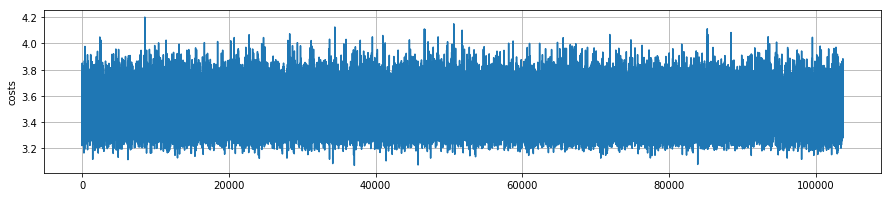

Nearest to <sos>: jptt, my, 跟, ,, 覺得, 樓上, 也, from, 原, 我,
Nearest to 我: 你, 他, 妳, 她, 我們, 有人, 女生, 他們, <sos>, 也,
Nearest to 台灣: 雷神, 可恥, 先請, 日本, 夜深, 三人, yahoo, 星期三, 棄之可惜, 騎上來,
Nearest to 工作: 公司, 價位, 會場, 事情, 第一天, 行員, 交往, 面試, 小弟, 拔牙,
Nearest to 喜歡: 討厭, 愛, 覺得, 想要, 適合, 說不過去, 好看, 人真, 吃, 和,
Nearest to 可以: 能, 要, 會, 建議, 只能, 海關, 不能, 不錯, 可, 想,
Nearest to 約: atm, 窮, 銷魂, 塊, 要花, 円, 毒龍, 單身, 990, 表妹,
Nearest to 電影: 片, 蘇格拉底, 角色, 再度, 一部, 小雞, 動畫, 見諒, 圖王, 遊戲,
Nearest to 時間: 開車, 上菜, 自盡, 的但, ?沒, 無可, 去過, 豁然開朗, 墊高, 小護士,
Nearest to 滿足: 小於, 基金會, 呷, 矯正, 喜事, 自律, 精神分裂, 描述, 付出, 樂意,
Nearest to 閃光: 過戶, sense, 稱為, 新車, 卡費, 射完, 吳淡如, jj, 課堂, 白髮,
Nearest to <eos>: xd, ?, !, 嗎, sent, @, xddd, =, my, from,

epoch5
Iteration  10371  ( 10.0 %) Train mean loss:  3.4676223  ( std:  0.122812964 ) ; run time:  30 [s]
Iteration  20734  ( 20.0 %) Train mean loss:  3.4676542  ( std:  0.123559296 ) ; run time:  61 [s]
Iteration  31099  ( 30.0 %) Train mean loss:  3.4674134  ( std:  0.12313477 ) ; run time:  91 [s]
Iteration  41476  ( 40.

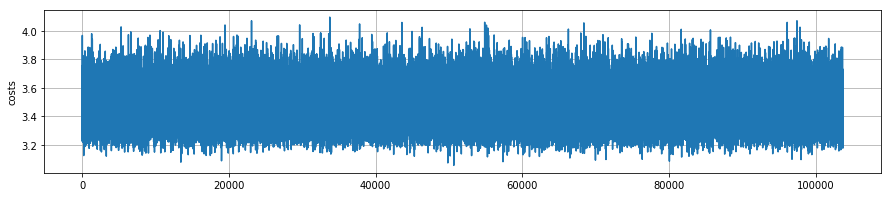

Nearest to <sos>: jptt, ,, 跟, my, 覺得, from, 樓上, 也, 原, 把,
Nearest to 我: 你, 他, 她, 妳, 我們, 有人, 女生, 他們, 自己, 男友,
Nearest to 台灣: 日本, 雷神, 可恥, 先請, yahoo, 夜深, 三人, 分段, 棄之可惜, 騎上來,
Nearest to 工作: 公司, 價位, 會場, 事情, 第一天, 面試, 小弟, 交往, 行員, 槍彈,
Nearest to 喜歡: 愛, 討厭, 適合, 覺得, 想要, 好看, 說不過去, 人真, 和, 推薦,
Nearest to 可以: 能, 要, 會, 不能, 只能, 建議, 可, 海關, 需要, 不錯,
Nearest to 約: atm, 窮, 塊, 円, 銷魂, 毒龍, 要花, 單身, 種田, 990,
Nearest to 電影: 片, 一部, 角色, 動畫, 蘇格拉底, 再度, 遊戲, 小雞, 作品, 見諒,
Nearest to 時間: 開車, 上菜, 自盡, 豁然開朗, ?沒, 的但, 去過, 無可, 布料, 3.6,
Nearest to 滿足: 小於, 基金會, 呷, 矯正, 喜事, 精神分裂, 自律, 付出, 描述, 樂意,
Nearest to 閃光: 過戶, 新車, sense, 稱為, 卡費, 射完, 吳淡如, jj, 課堂, 女兒,
Nearest to <eos>: xd, ?, !, 嗎, sent, @, =, xddd, my, from,

epoch6
Iteration  10364  ( 10.0 %) Train mean loss:  3.4462357  ( std:  0.12163235 ) ; run time:  30 [s]
Iteration  20736  ( 20.0 %) Train mean loss:  3.4481657  ( std:  0.12021761 ) ; run time:  61 [s]
Iteration  31117  ( 30.0 %) Train mean loss:  3.4479947  ( std:  0.1208232 ) ; run time:  91 [s]
Iteration  41487  ( 40.0 %)

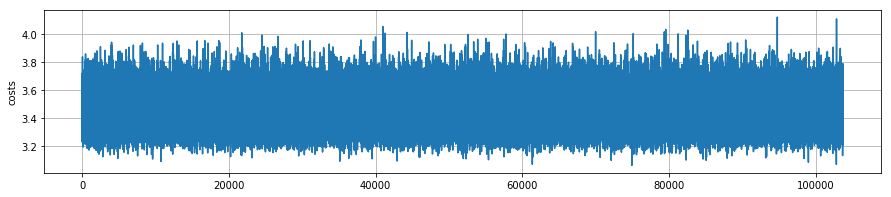

Nearest to <sos>: jptt, my, 跟, 覺得, ,, from, 也, 樓上, on, 把,
Nearest to 我: 你, 他, 她, 妳, 我們, 女生, 有人, 自己, 男友, 大家,
Nearest to 台灣: 日本, 雷神, 可恥, yahoo, 中國, 先請, 夜深, 三人, 分段, 星期三,
Nearest to 工作: 公司, 價位, 事情, 面試, 會場, 第一天, 小弟, 交往, 槍彈, 行員,
Nearest to 喜歡: 愛, 討厭, 適合, 覺得, 想要, 好看, 說不過去, 推薦, 人真, 對,
Nearest to 可以: 能, 要, 會, 不能, 可, 只能, 建議, 需要, 不錯, 不要,
Nearest to 約: atm, 窮, 塊, 円, 毒龍, 銷魂, 要花, 種田, 單身, 990,
Nearest to 電影: 片, 一部, 動畫, 蘇格拉底, 角色, 作品, 遊戲, 再度, 親愛, 聯盟,
Nearest to 時間: 開車, 上菜, 自盡, 豁然開朗, 的但, 去過, ?沒, 3.6, 地方, 布料,
Nearest to 滿足: 小於, 基金會, 呷, 喜事, 矯正, 精神分裂, 付出, 自律, 描述, 樂意,
Nearest to 閃光: 新車, 過戶, 稱為, sense, 卡費, 射完, 吳淡如, jj, 女兒, 白髮,
Nearest to <eos>: xd, !, ?, 嗎, sent, xddd, =, @, my, from,

epoch7
Iteration  10365  ( 10.0 %) Train mean loss:  3.432351  ( std:  0.120280676 ) ; run time:  30 [s]
Iteration  20741  ( 20.0 %) Train mean loss:  3.433264  ( std:  0.120190755 ) ; run time:  60 [s]
Iteration  31118  ( 30.0 %) Train mean loss:  3.4338758  ( std:  0.1202354 ) ; run time:  91 [s]
Iteration  41494  ( 40.0 %) 

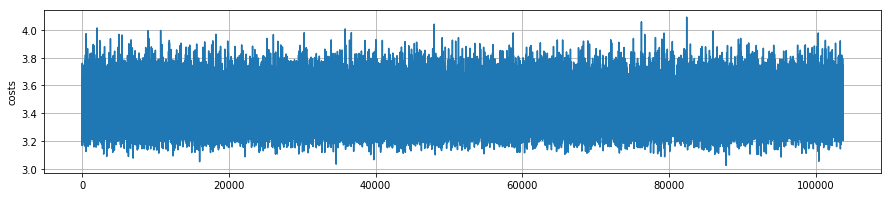

Nearest to <sos>: jptt, ,, 覺得, 跟, my, from, 也, on, 樓上, 在,
Nearest to 我: 你, 他, 她, 妳, 我們, 女生, 有人, 自己, 男友, 大家,
Nearest to 台灣: 日本, 中國, 雷神, yahoo, 可恥, 先請, 夜深, 三人, 分段, 星期三,
Nearest to 工作: 公司, 面試, 事情, 價位, 會場, 小弟, 第一天, 交往, 薪水, 前景,
Nearest to 喜歡: 愛, 討厭, 適合, 覺得, 想要, 好看, 推薦, 說不過去, 人真, 對,
Nearest to 可以: 能, 要, 會, 不能, 可, 只能, 建議, 需要, 不要, 不錯,
Nearest to 約: atm, 窮, 塊, 円, 毒龍, 銷魂, 種田, 要花, 單身, 990,
Nearest to 電影: 片, 一部, 動畫, 作品, 蘇格拉底, 角色, 看, 遊戲, 劇情, 小說,
Nearest to 時間: 上菜, 開車, 自盡, 豁然開朗, 去過, 的但, 3.6, 婚假, 地方, 布料,
Nearest to 滿足: 小於, 基金會, 呷, 喜事, 精神分裂, 付出, 矯正, 描述, 樂意, 自律,
Nearest to 閃光: 新車, 稱為, 過戶, sense, 射完, 卡費, 吳淡如, jj, 女兒, 合理化,
Nearest to <eos>: xd, !, ?, 嗎, sent, xddd, =, @, my, from,

epoch8
Iteration  10379  ( 10.0 %) Train mean loss:  3.4206338  ( std:  0.117814936 ) ; run time:  30 [s]
Iteration  20751  ( 20.0 %) Train mean loss:  3.4210267  ( std:  0.117341086 ) ; run time:  61 [s]
Iteration  31114  ( 30.0 %) Train mean loss:  3.421795  ( std:  0.11742615 ) ; run time:  91 [s]
Iteration  41487  ( 40.0 %

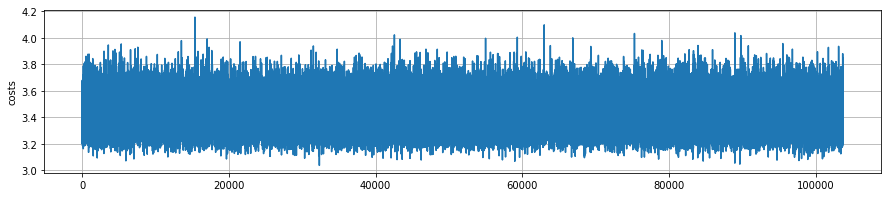

Nearest to <sos>: jptt, ,, 跟, my, 覺得, from, 也, 樓上, on, 把,
Nearest to 我: 你, 他, 她, 妳, 我們, 男友, 自己, 女生, 有人, 大家,
Nearest to 台灣: 日本, 中國, yahoo, 雷神, 可恥, 先請, 三人, 美國, 夜深, 每年,
Nearest to 工作: 公司, 事情, 面試, 價位, 會場, 小弟, 第一天, 交往, 薪水, 前景,
Nearest to 喜歡: 愛, 討厭, 適合, 覺得, 好看, 想要, 推薦, 說不過去, 對, 人真,
Nearest to 可以: 能, 要, 可, 不能, 會, 只能, 建議, 需要, 不要, 來,
Nearest to 約: 窮, 円, 塊, atm, 毒龍, 銷魂, firefox, 種田, 990, 單身,
Nearest to 電影: 片, 一部, 動畫, 作品, 蘇格拉底, 角色, 這部, 小說, 親愛, 劇情,
Nearest to 時間: 上菜, 開車, 豁然開朗, 自盡, 婚假, 我付, 3.6, 地方, 去過, 布料,
Nearest to 滿足: 小於, 基金會, 呷, 喜事, 精神分裂, 付出, 描述, 矯正, 樂意, 找間,
Nearest to 閃光: 新車, 稱為, 過戶, sense, 射完, 卡費, 吳淡如, jj, 合理化, 女兒,
Nearest to <eos>: xd, !, ?, sent, 嗎, xddd, @, =, xdd, my,

epoch9
Iteration  10376  ( 10.0 %) Train mean loss:  3.4097798  ( std:  0.116613224 ) ; run time:  31 [s]
Iteration  20744  ( 20.0 %) Train mean loss:  3.4109855  ( std:  0.11721923 ) ; run time:  61 [s]
Iteration  31115  ( 30.0 %) Train mean loss:  3.4112158  ( std:  0.1172892 ) ; run time:  92 [s]
Iteration  41497  ( 40.0

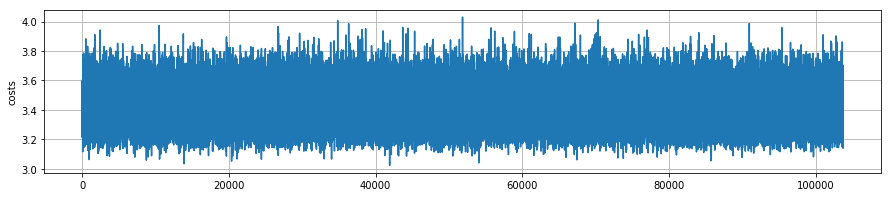

Nearest to <sos>: jptt, ,, 覺得, my, 跟, from, on, 也, 把, 樓上,
Nearest to 我: 他, 你, 她, 妳, 我們, 自己, 男友, 大家, 女生, 有人,
Nearest to 台灣: 日本, 中國, yahoo, 雷神, 美國, 可恥, 先請, 三人, 好萊塢, 分段,
Nearest to 工作: 公司, 事情, 面試, 會場, 薪水, 價位, 小弟, 交往, 前景, 第一天,
Nearest to 喜歡: 愛, 討厭, 適合, 覺得, 想要, 好看, 推薦, 對, 說不過去, 超愛,
Nearest to 可以: 能, 要, 可, 不能, 會, 只能, 需要, 建議, 不錯, 不用,
Nearest to 約: 円, 塊, 窮, 毒龍, atm, 銷魂, firefox, 種田, 990, 時辰,
Nearest to 電影: 片, 一部, 動畫, 作品, 這部, 角色, 蘇格拉底, 小說, 劇情, 親愛,
Nearest to 時間: 上菜, 開車, 婚假, 豁然開朗, 我付, 自盡, 地方, 3.6, 去過, 撐過去,
Nearest to 滿足: 小於, 呷, 基金會, 描述, 精神分裂, 喜事, 付出, 樂意, 矯正, 找間,
Nearest to 閃光: 新車, 稱為, 射完, 過戶, sense, 卡費, 吳淡如, jj, 女兒, 合理化,
Nearest to <eos>: xd, !, ?, sent, 嗎, xddd, =, @, xdd, my,

epoch10
Iteration  10375  ( 10.0 %) Train mean loss:  3.4005365  ( std:  0.115898915 ) ; run time:  30 [s]
Iteration  20752  ( 20.0 %) Train mean loss:  3.4014966  ( std:  0.11601648 ) ; run time:  60 [s]
Iteration  31126  ( 30.0 %) Train mean loss:  3.4019732  ( std:  0.1159829 ) ; run time:  91 [s]
Iteration  41488  ( 

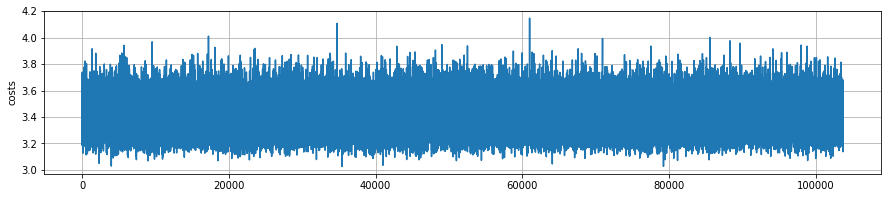

Nearest to <sos>: jptt, ,, 覺得, 跟, from, my, 也, on, 把, 樓上,
Nearest to 我: 他, 你, 她, 妳, 我們, 自己, 大家, 女生, 男友, 小弟,
Nearest to 台灣: 日本, 中國, yahoo, 美國, 雷神, 可恥, 先請, 分段, 好萊塢, 產業,
Nearest to 工作: 公司, 事情, 面試, 薪水, 會場, 小弟, 前景, 交往, 價位, 第一天,
Nearest to 喜歡: 愛, 討厭, 適合, 覺得, 好看, 想要, 推薦, 超愛, 對, 好奇,
Nearest to 可以: 能, 要, 可, 不能, 會, 只能, 不要, 需要, 不錯, 不用,
Nearest to 約: 円, 塊, 窮, 毒龍, 銷魂, atm, firefox, 種田, 990, 時辰,
Nearest to 電影: 片, 一部, 動畫, 作品, 這部, 蘇格拉底, 角色, 小說, 劇情, 親愛,
Nearest to 時間: 上菜, 開車, 婚假, 我付, 豁然開朗, 地方, 撐過去, 樂透, 3.6, 中天,
Nearest to 滿足: 小於, 呷, 基金會, 描述, 精神分裂, 付出, 喜事, 樂意, 找間, 矯正,
Nearest to 閃光: 新車, 稱為, 射完, 過戶, 卡費, sense, 吳淡如, jj, 聊天, 女兒,
Nearest to <eos>: xd, !, ?, sent, 嗎, xddd, =, @, xdd, my,

epoch11
Iteration  10365  ( 10.0 %) Train mean loss:  3.3926218  ( std:  0.11594 ) ; run time:  31 [s]
Iteration  20735  ( 20.0 %) Train mean loss:  3.393429  ( std:  0.11513754 ) ; run time:  62 [s]
Iteration  31100  ( 30.0 %) Train mean loss:  3.393844  ( std:  0.11551564 ) ; run time:  93 [s]
Iteration  41479  ( 40.0 %) 

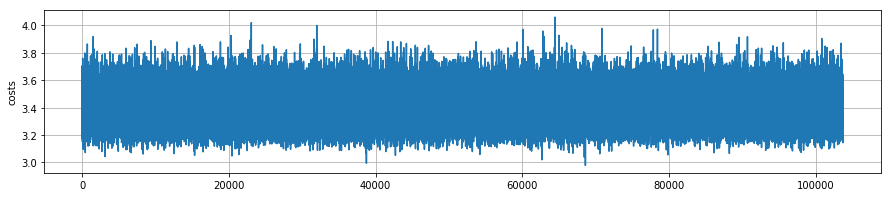

Nearest to <sos>: jptt, ,, 覺得, 跟, from, my, 也, on, 把, 樓上,
Nearest to 我: 你, 他, 她, 妳, 我們, 有人, 大家, 小弟, 男友, 自己,
Nearest to 台灣: 日本, 中國, 美國, yahoo, 雷神, 可恥, 先請, 好萊塢, 分段, 產業,
Nearest to 工作: 公司, 事情, 面試, 薪水, 會場, 前景, 交往, 小弟, 第一天, 發展,
Nearest to 喜歡: 愛, 討厭, 適合, 覺得, 想要, 好看, 推薦, 超愛, 好奇, 對,
Nearest to 可以: 能, 要, 可, 不能, 會, 只能, 不錯, 不要, 需要, 不用,
Nearest to 約: 円, 塊, 窮, 毒龍, firefox, 銷魂, 時辰, 種田, atm, 南希,
Nearest to 電影: 片, 一部, 動畫, 作品, 這部, 蘇格拉底, 小說, 角色, 劇情, 拍,
Nearest to 時間: 開車, 上菜, 婚假, 我付, 撐過去, 豁然開朗, 地方, 中天, 樂透, 3.6,
Nearest to 滿足: 小於, 呷, 基金會, 描述, 精神分裂, 喜事, 付出, 樂意, 找間, 波多野,
Nearest to 閃光: 新車, 稱為, 射完, 過戶, 卡費, 吳淡如, 女友, 男友, sense, 聊天,
Nearest to <eos>: xd, !, ?, sent, 嗎, xddd, xdd, =, my, from,

epoch12
Iteration  10373  ( 10.0 %) Train mean loss:  3.3872108  ( std:  0.113249205 ) ; run time:  30 [s]
Iteration  20736  ( 20.0 %) Train mean loss:  3.3879025  ( std:  0.11369306 ) ; run time:  61 [s]
Iteration  31108  ( 30.0 %) Train mean loss:  3.3884075  ( std:  0.11386873 ) ; run time:  92 [s]
Iteration  41482  ( 

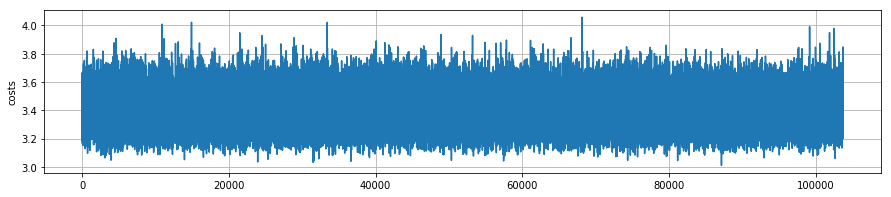

Nearest to <sos>: jptt, ,, 覺得, 跟, from, my, on, 也, 其實, 把,
Nearest to 我: 他, 你, 她, 妳, 我們, 大家, 小弟, 有人, 自己, 男友,
Nearest to 台灣: 日本, 中國, 美國, yahoo, 雷神, 可恥, 產業, 分段, 先請, 好萊塢,
Nearest to 工作: 公司, 事情, 面試, 薪水, 會場, 交往, 前景, 小弟, 發展, 科技,
Nearest to 喜歡: 愛, 討厭, 適合, 覺得, 想要, 推薦, 好看, 超愛, 對, 好奇,
Nearest to 可以: 能, 要, 可, 不能, 會, 只能, 不要, 不用, 不錯, 無法,
Nearest to 約: 円, 塊, 毒龍, 窮, 銷魂, firefox, 時辰, 南希, 種田, 職業病,
Nearest to 電影: 片, 一部, 作品, 動畫, 這部, 小說, 蘇格拉底, 角色, 漫畫, 拍,
Nearest to 時間: 開車, 上菜, 婚假, 我付, 撐過去, 中天, 樂透, 豁然開朗, 游, 3.6,
Nearest to 滿足: 小於, 呷, 描述, 基金會, 精神分裂, 喜事, 付出, 樂意, 找間, 波多野,
Nearest to 閃光: 新車, 稱為, 射完, 女友, 男友, 卡費, 過戶, 吳淡如, 聊天, jj,
Nearest to <eos>: xd, !, ?, sent, 嗎, xddd, xdd, =, from, my,

epoch13
Iteration  10374  ( 10.0 %) Train mean loss:  3.3794312  ( std:  0.114527166 ) ; run time:  30 [s]
Iteration  20751  ( 20.0 %) Train mean loss:  3.3807716  ( std:  0.11396434 ) ; run time:  60 [s]
Iteration  31127  ( 30.0 %) Train mean loss:  3.3813522  ( std:  0.11378703 ) ; run time:  91 [s]
Iteration  41493  ( 40.0 

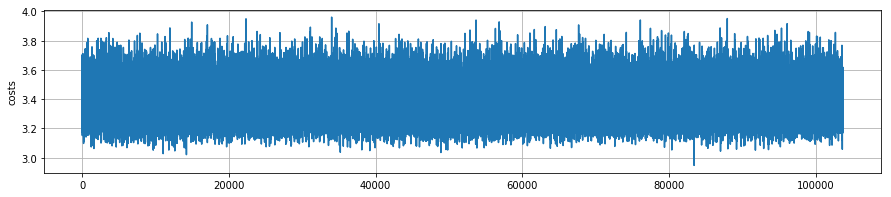

Nearest to <sos>: jptt, ,, 覺得, 跟, from, my, on, 也, 把, 其實,
Nearest to 我: 他, 你, 她, 妳, 我們, 小弟, 大家, 自己, 有人, 男友,
Nearest to 台灣: 日本, 中國, 美國, yahoo, 雷神, 可恥, 好萊塢, 臺灣, 產業, 分段,
Nearest to 工作: 公司, 事情, 薪水, 面試, 交往, 會場, 發展, 前景, 上班, 科技,
Nearest to 喜歡: 愛, 討厭, 適合, 覺得, 想要, 推薦, 好看, 超愛, 好奇, 對,
Nearest to 可以: 能, 要, 可, 不能, 會, 只能, 無法, 不要, 願意, 不用,
Nearest to 約: 円, 毒龍, 窮, 塊, firefox, 銷魂, 南希, 職業病, 種田, 時辰,
Nearest to 電影: 片, 一部, 動畫, 作品, 這部, 小說, 拍, 漫畫, 角色, 蘇格拉底,
Nearest to 時間: 上菜, 開車, 我付, 婚假, 撐過去, 樂透, 中天, 游, 豁然開朗, 降,
Nearest to 滿足: 小於, 呷, 描述, 基金會, 精神分裂, 付出, 樂意, 喜事, 找間, 波多野,
Nearest to 閃光: 新車, 稱為, 女友, 射完, 男友, 卡費, 她, 吳淡如, 聊天, 過戶,
Nearest to <eos>: xd, !, ?, sent, 嗎, xdd, xddd, from, =, @,

epoch14
Iteration  10364  ( 10.0 %) Train mean loss:  3.3742135  ( std:  0.11253448 ) ; run time:  36 [s]
Iteration  20723  ( 20.0 %) Train mean loss:  3.3749804  ( std:  0.11266566 ) ; run time:  69 [s]
Iteration  31093  ( 30.0 %) Train mean loss:  3.375321  ( std:  0.11269641 ) ; run time:  101 [s]
Iteration  41473  ( 40.0 %) Tr

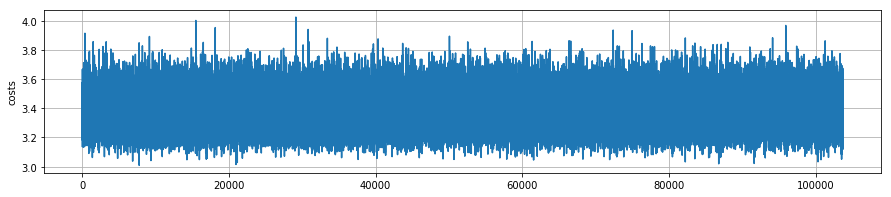

Nearest to <sos>: jptt, ,, 覺得, from, 跟, my, on, 把, 也, 樓上,
Nearest to 我: 他, 你, 她, 妳, 小弟, 我們, 大家, 自己, 男友, 有人,
Nearest to 台灣: 日本, 中國, 美國, yahoo, 雷神, 臺灣, 可恥, 好萊塢, 產業, 分段,
Nearest to 工作: 公司, 事情, 薪水, 面試, 交往, 發展, 會場, 上班, 前景, 科技,
Nearest to 喜歡: 愛, 討厭, 適合, 覺得, 推薦, 想要, 好看, 超愛, 最愛, 好奇,
Nearest to 可以: 能, 要, 可, 不能, 會, 只能, 不用, 不要, 無法, 願意,
Nearest to 約: 円, 毒龍, 塊, 窮, firefox, 南希, 銷魂, 種田, 職業病, 時辰,
Nearest to 電影: 片, 一部, 作品, 動畫, 這部, 小說, 拍, 漫畫, 蘇格拉底, 角色,
Nearest to 時間: 上菜, 開車, 婚假, 我付, 撐過去, 樂透, 中天, 游, 降, 豁然開朗,
Nearest to 滿足: 小於, 描述, 呷, 基金會, 精神分裂, 樂意, 付出, 找間, 波多野, 喜事,
Nearest to 閃光: 新車, 稱為, 女友, 射完, 男友, 她, 卡費, 聊天, 吳淡如, 合理化,
Nearest to <eos>: xd, !, ?, sent, 嗎, xdd, xddd, from, =, my,

epoch15
Iteration  10383  ( 10.0 %) Train mean loss:  3.3684185  ( std:  0.11294983 ) ; run time:  30 [s]
Iteration  20758  ( 20.0 %) Train mean loss:  3.3695912  ( std:  0.11242885 ) ; run time:  61 [s]
Iteration  31124  ( 30.0 %) Train mean loss:  3.3702579  ( std:  0.11241172 ) ; run time:  91 [s]
Iteration  41503  ( 40.0 %)

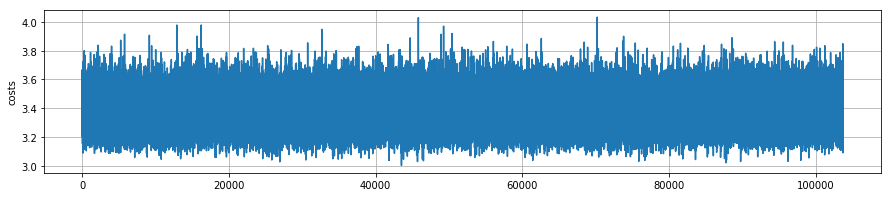

Nearest to <sos>: jptt, ,, 覺得, 跟, from, my, on, 把, 也, 樓上,
Nearest to 我: 他, 你, 她, 妳, 小弟, 我們, 大家, 自己, 男友, 有人,
Nearest to 台灣: 日本, 中國, 美國, yahoo, 臺灣, 雷神, 可恥, 產業, 好萊塢, 大陸,
Nearest to 工作: 公司, 薪水, 事情, 面試, 上班, 交往, 發展, 前景, 會場, 科技,
Nearest to 喜歡: 愛, 討厭, 適合, 覺得, 推薦, 超愛, 想要, 好看, 最愛, 習慣,
Nearest to 可以: 能, 要, 可, 不能, 會, 只能, 無法, 願意, 不用, 不要,
Nearest to 約: 円, 毒龍, 塊, 窮, firefox, 南希, 職業病, 銷魂, 還錢, 種田,
Nearest to 電影: 片, 一部, 作品, 動畫, 這部, 小說, 拍, 漫畫, 蘇格拉底, 角色,
Nearest to 時間: 上菜, 開車, 婚假, 撐過去, 我付, 中天, 樂透, 游, 降, .而且,
Nearest to 滿足: 小於, 描述, 呷, 樂意, 精神分裂, 基金會, 付出, 找間, 波多野, 開說,
Nearest to 閃光: 女友, 新車, 男友, 稱為, 射完, 她, 卡費, 聊天, 合理化, jj,
Nearest to <eos>: xd, !, sent, ?, 嗎, xdd, xddd, from, my, =,

epoch16
Iteration  10379  ( 10.0 %) Train mean loss:  3.3640332  ( std:  0.112669215 ) ; run time:  32 [s]
Iteration  20741  ( 20.0 %) Train mean loss:  3.364892  ( std:  0.11190096 ) ; run time:  63 [s]
Iteration  31110  ( 30.0 %) Train mean loss:  3.3654704  ( std:  0.11188652 ) ; run time:  93 [s]
Iteration  41478  ( 40.0 %) T

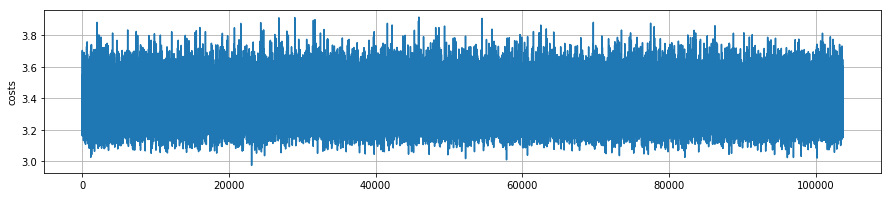

Nearest to <sos>: jptt, ,, from, 覺得, 跟, my, on, 把, 也, 讓,
Nearest to 我: 他, 你, 她, 妳, 小弟, 自己, 我們, 大家, 有人, 對方,
Nearest to 台灣: 日本, 中國, 美國, yahoo, 臺灣, 可恥, 雷神, 產業, 好萊塢, 大陸,
Nearest to 工作: 公司, 薪水, 事情, 面試, 上班, 發展, 交往, 前景, 會場, 科技,
Nearest to 喜歡: 討厭, 愛, 適合, 覺得, 想要, 推薦, 超愛, 好看, 最愛, 習慣,
Nearest to 可以: 能, 可, 要, 不能, 會, 只能, 無法, 願意, 不用, 不要,
Nearest to 約: 円, 毒龍, 塊, 窮, 南希, 還錢, firefox, 職業病, 時辰, 種田,
Nearest to 電影: 片, 一部, 作品, 動畫, 這部, 小說, 漫畫, 拍, 蘇格拉底, 發行,
Nearest to 時間: 上菜, 開車, 婚假, 撐過去, 我付, 中天, 樂透, 游, 降, 忙,
Nearest to 滿足: 小於, 描述, 呷, 樂意, 精神分裂, 波多野, 基金會, 找間, 開說, 付出,
Nearest to 閃光: 女友, 男友, 新車, 稱為, 射完, 她, 卡費, 聊天, 合理化, jj,
Nearest to <eos>: xd, !, sent, ?, 嗎, xdd, xddd, from, my, =,

epoch17
Iteration  10365  ( 10.0 %) Train mean loss:  3.3597558  ( std:  0.11208518 ) ; run time:  33 [s]
Iteration  20738  ( 20.0 %) Train mean loss:  3.359531  ( std:  0.111816354 ) ; run time:  63 [s]
Iteration  31119  ( 30.0 %) Train mean loss:  3.3603806  ( std:  0.11121422 ) ; run time:  94 [s]
Iteration  41492  ( 40.0 %) Trai

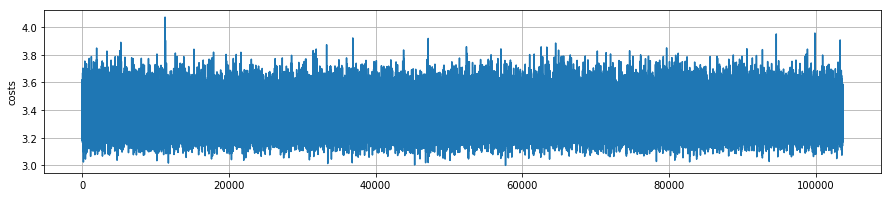

Nearest to <sos>: jptt, ,, 覺得, from, 跟, my, on, 把, 也, 在,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 自己, 我們, 有人, 對方,
Nearest to 台灣: 日本, 中國, 美國, yahoo, 臺灣, 產業, 雷神, 可恥, 好萊塢, 大陸,
Nearest to 工作: 公司, 薪水, 事情, 上班, 面試, 交往, 發展, 會場, 前景, 科技,
Nearest to 喜歡: 討厭, 愛, 適合, 覺得, 超愛, 想要, 推薦, 好看, 最愛, 習慣,
Nearest to 可以: 能, 可, 要, 不能, 會, 只能, 無法, 願意, 能夠, 還能,
Nearest to 約: 円, 毒龍, 窮, 南希, 塊, 還錢, firefox, 職業病, 種田, 時辰,
Nearest to 電影: 片, 一部, 作品, 動畫, 這部, 小說, 漫畫, 拍, 片子, 發行,
Nearest to 時間: 上菜, 開車, 撐過去, 婚假, 樂透, 我付, 中天, 游, 降, 龍貓,
Nearest to 滿足: 小於, 描述, 呷, 樂意, 精神分裂, 開說, 波多野, 找間, 基金會, 付出,
Nearest to 閃光: 女友, 男友, 新車, 稱為, 射完, 她, 卡費, 聊天, 合理化, jj,
Nearest to <eos>: xd, !, sent, ?, 嗎, xdd, xddd, from, my, =,

epoch18
Iteration  10371  ( 10.0 %) Train mean loss:  3.3542268  ( std:  0.11168802 ) ; run time:  30 [s]
Iteration  20749  ( 20.0 %) Train mean loss:  3.3551443  ( std:  0.11118552 ) ; run time:  60 [s]
Iteration  31116  ( 30.0 %) Train mean loss:  3.3555696  ( std:  0.11090486 ) ; run time:  91 [s]
Iteration  41491  ( 40.0 %) Train

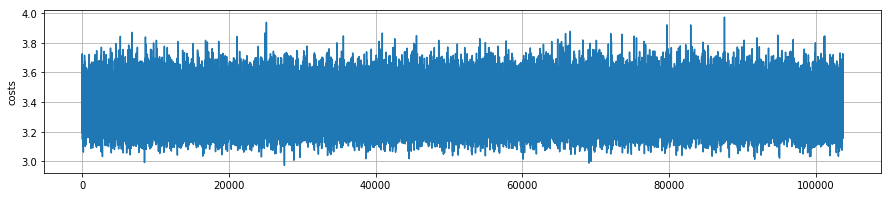

Nearest to <sos>: jptt, ,, 覺得, from, 跟, my, on, 把, 也, 樓上,
Nearest to 我: 他, 你, 她, 妳, 小弟, 我們, 大家, 自己, 對方, 男友,
Nearest to 台灣: 日本, 中國, 美國, yahoo, 臺灣, 可恥, 好萊塢, 大陸, 產業, 雷神,
Nearest to 工作: 公司, 薪水, 上班, 事情, 發展, 交往, 面試, 前景, 會場, 科技,
Nearest to 喜歡: 討厭, 愛, 適合, 覺得, 推薦, 超愛, 想要, 好看, 最愛, 習慣,
Nearest to 可以: 能, 可, 要, 不能, 會, 只能, 願意, 還能, 無法, 能夠,
Nearest to 約: 円, 毒龍, 南希, 窮, 塊, 還錢, firefox, 職業病, 種田, 他媽,
Nearest to 電影: 片, 一部, 作品, 這部, 動畫, 小說, 漫畫, 拍, 片子, 發行,
Nearest to 時間: 上菜, 開車, 撐過去, 婚假, 樂透, 中天, 我付, 游, 忙, 降,
Nearest to 滿足: 小於, 描述, 呷, 樂意, 精神分裂, 開說, 找間, 波多野, 幽默, 付出,
Nearest to 閃光: 男友, 女友, 新車, 射完, 稱為, 她, 卡費, 現任, 聊天, 合理化,
Nearest to <eos>: xd, !, sent, ?, 嗎, xdd, xddd, from, =, my,

epoch19
Iteration  10367  ( 10.0 %) Train mean loss:  3.350849  ( std:  0.109226026 ) ; run time:  30 [s]
Iteration  20745  ( 20.0 %) Train mean loss:  3.3511975  ( std:  0.10994844 ) ; run time:  62 [s]
Iteration  31111  ( 30.0 %) Train mean loss:  3.3515959  ( std:  0.11020628 ) ; run time:  93 [s]
Iteration  41474  ( 40.0 %) Train 

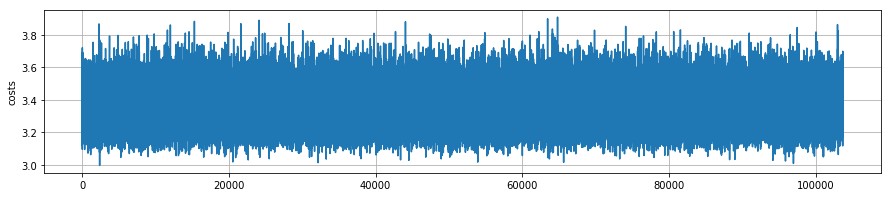

Nearest to <sos>: jptt, ,, 覺得, 跟, from, my, on, 把, 也, 在,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 自己, 我們, 對方, 男友,
Nearest to 台灣: 日本, 中國, 美國, 臺灣, yahoo, 韓國, 產業, 大陸, 可恥, 亞洲,
Nearest to 工作: 公司, 薪水, 上班, 事情, 發展, 交往, 面試, 前景, 會場, 生活,
Nearest to 喜歡: 討厭, 愛, 適合, 覺得, 超愛, 推薦, 想要, 好看, 最愛, 習慣,
Nearest to 可以: 能, 可, 要, 不能, 會, 只能, 能夠, 願意, 無法, 還能,
Nearest to 約: 円, 毒龍, 南希, 還錢, 窮, firefox, 塊, 職業病, 時辰, 他媽,
Nearest to 電影: 片, 一部, 作品, 這部, 動畫, 小說, 漫畫, 拍, 片子, 發行,
Nearest to 時間: 上菜, 開車, 撐過去, 樂透, 婚假, 我付, 中天, 游, 降, 龍貓,
Nearest to 滿足: 小於, 描述, 呷, 樂意, 開說, 精神分裂, 波多野, 找間, 幽默, 呼叫,
Nearest to 閃光: 男友, 女友, 新車, 射完, 稱為, 她, 現任, 聊天, 卡費, 合理化,
Nearest to <eos>: xd, !, sent, ?, 嗎, xdd, xddd, from, =, my,

epoch20
Iteration  10377  ( 10.0 %) Train mean loss:  3.3474495  ( std:  0.10956839 ) ; run time:  30 [s]
Iteration  20740  ( 20.0 %) Train mean loss:  3.3487122  ( std:  0.10934865 ) ; run time:  61 [s]
Iteration  31108  ( 30.0 %) Train mean loss:  3.3492806  ( std:  0.10936161 ) ; run time:  91 [s]
Iteration  41492  ( 40.0 %) Train m

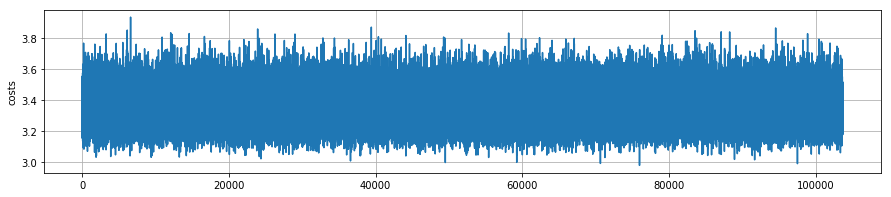

Nearest to <sos>: jptt, ,, from, 跟, 覺得, on, my, 把, 也, 在,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 自己, 我們, 男友, 對方,
Nearest to 台灣: 日本, 中國, 美國, 臺灣, yahoo, 產業, 韓國, 亞洲, 大陸, 可恥,
Nearest to 工作: 公司, 薪水, 上班, 事情, 發展, 交往, 面試, 前景, 會場, 科技,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 覺得, 推薦, 想要, 最愛, 好看, 習慣,
Nearest to 可以: 能, 可, 要, 不能, 會, 只能, 能夠, 還能, 願意, 無法,
Nearest to 約: 円, 毒龍, 南希, firefox, 窮, 還錢, 塊, 職業病, 他媽, 時辰,
Nearest to 電影: 片, 一部, 這部, 作品, 動畫, 小說, 漫畫, 拍, 片子, 發行,
Nearest to 時間: 上菜, 開車, 撐過去, 樂透, 我付, 婚假, 中天, 游, 龍貓, 忙,
Nearest to 滿足: 小於, 描述, 呷, 樂意, 開說, 波多野, 幽默, 精神分裂, 找間, 呼叫,
Nearest to 閃光: 男友, 女友, 新車, 射完, 稱為, 她, 現任, 合理化, 卡費, 朋友,
Nearest to <eos>: xd, !, sent, ?, 嗎, xdd, xddd, from, my, =,

epoch21
Iteration  10365  ( 10.0 %) Train mean loss:  3.3432705  ( std:  0.10836014 ) ; run time:  30 [s]
Iteration  20742  ( 20.0 %) Train mean loss:  3.3449297  ( std:  0.10827154 ) ; run time:  60 [s]
Iteration  31118  ( 30.0 %) Train mean loss:  3.3454072  ( std:  0.10860837 ) ; run time:  91 [s]
Iteration  41484  ( 40.0 %) Train m

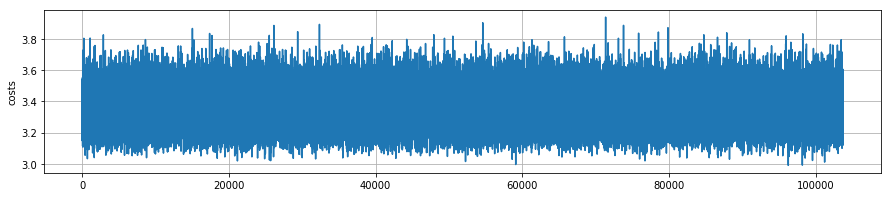

Nearest to <sos>: jptt, ,, from, 覺得, 跟, my, on, 把, 也, 在,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 我們, 自己, 對方, 有人,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 大陸, 韓國, 亞洲, 好萊塢, 可恥,
Nearest to 工作: 薪水, 公司, 上班, 發展, 事情, 交往, 面試, 前景, 會場, 生活,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 覺得, 推薦, 想要, 最愛, 好看, 習慣,
Nearest to 可以: 能, 可, 要, 不能, 會, 只能, 能夠, 還能, 願意, 無法,
Nearest to 約: 円, 南希, 毒龍, firefox, 窮, 還錢, 塊, 時辰, 職業病, 他媽,
Nearest to 電影: 片, 一部, 這部, 動畫, 作品, 小說, 片子, 漫畫, 拍, 發行,
Nearest to 時間: 上菜, 開車, 撐過去, 樂透, 我付, 中天, 婚假, 忙, 游, 降,
Nearest to 滿足: 小於, 描述, 呷, 樂意, 開說, 幽默, 呼叫, 精神分裂, 波多野, 找間,
Nearest to 閃光: 男友, 女友, 新車, 射完, 稱為, 她, 現任, 合理化, 我, 卡費,
Nearest to <eos>: xd, sent, !, ?, 嗎, xdd, xddd, from, my, =,

epoch22
Iteration  10363  ( 10.0 %) Train mean loss:  3.3407133  ( std:  0.10732529 ) ; run time:  30 [s]
Iteration  20731  ( 20.0 %) Train mean loss:  3.3412576  ( std:  0.10834354 ) ; run time:  61 [s]
Iteration  31104  ( 30.0 %) Train mean loss:  3.3412333  ( std:  0.1085042 ) ; run time:  91 [s]
Iteration  41475  ( 40.0 %) Train mea

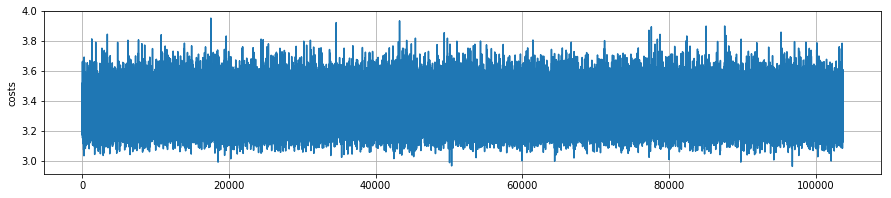

Nearest to <sos>: jptt, ,, from, 跟, 覺得, my, on, 把, 在, 也,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 我們, 自己, 對方, 男友,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 大陸, 亞洲, 好萊塢, 可恥,
Nearest to 工作: 薪水, 公司, 上班, 事情, 發展, 交往, 面試, 前景, 會場, 生活,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 覺得, 推薦, 最愛, 想要, 好看, 習慣,
Nearest to 可以: 能, 可, 要, 不能, 會, 只能, 能夠, 願意, 還能, 無法,
Nearest to 約: 円, 南希, 毒龍, 還錢, firefox, 窮, 塊, 時辰, 職業病, 會射,
Nearest to 電影: 片, 一部, 這部, 作品, 動畫, 小說, 片子, 漫畫, 發行, 拍,
Nearest to 時間: 上菜, 開車, 撐過去, 樂透, 中天, 我付, 婚假, 忙, 降, 龍貓,
Nearest to 滿足: 小於, 描述, 呷, 樂意, 開說, 幽默, 呼叫, 找間, 波多野, 精神分裂,
Nearest to 閃光: 男友, 女友, 新車, 射完, 稱為, 她, 現任, 朋友, 合理化, 我,
Nearest to <eos>: xd, !, sent, ?, 嗎, xdd, xddd, from, 誤, my,

epoch23
Iteration  10375  ( 10.0 %) Train mean loss:  3.3363035  ( std:  0.10710238 ) ; run time:  30 [s]
Iteration  20752  ( 20.0 %) Train mean loss:  3.3373716  ( std:  0.107165776 ) ; run time:  61 [s]
Iteration  31120  ( 30.0 %) Train mean loss:  3.3382711  ( std:  0.10779207 ) ; run time:  91 [s]
Iteration  41482  ( 40.0 %) Train 

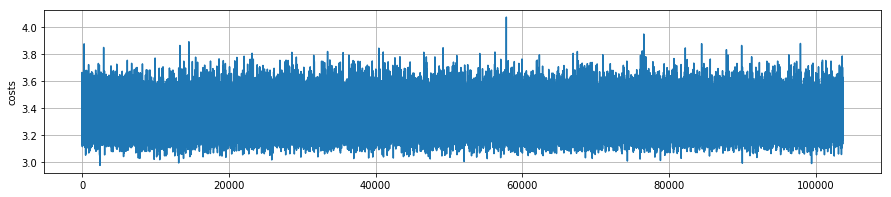

Nearest to <sos>: jptt, ,, from, 覺得, 跟, on, my, 把, 也, 在,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 我們, 自己, 對方, 有人,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 亞洲, 大陸, 可恥, 好萊塢,
Nearest to 工作: 薪水, 上班, 公司, 發展, 事情, 交往, 面試, 前景, 會場, 生活,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 覺得, 推薦, 最愛, 想要, 好看, 愛看,
Nearest to 可以: 能, 可, 要, 不能, 會, 能夠, 只能, 還能, 願意, 無法,
Nearest to 約: 円, 南希, 毒龍, 還錢, firefox, 窮, 塊, 時辰, 他媽, 職業病,
Nearest to 電影: 片, 一部, 作品, 動畫, 這部, 小說, 片子, 漫畫, 拍, 發行,
Nearest to 時間: 上菜, 開車, 撐過去, 樂透, 中天, 婚假, 我付, 星期一, 忙, 龍貓,
Nearest to 滿足: 小於, 描述, 呷, 樂意, 開說, 幽默, 呼叫, 找間, 精神分裂, 波多野,
Nearest to 閃光: 男友, 女友, 新車, 射完, 稱為, 現任, 她, 合理化, 前女友, jj,
Nearest to <eos>: xd, !, sent, ?, 嗎, xdd, xddd, from, my, =,

epoch24
Iteration  10372  ( 10.0 %) Train mean loss:  3.3323777  ( std:  0.108331665 ) ; run time:  30 [s]
Iteration  20740  ( 20.0 %) Train mean loss:  3.3337264  ( std:  0.10756978 ) ; run time:  60 [s]
Iteration  31108  ( 30.0 %) Train mean loss:  3.3347044  ( std:  0.10727401 ) ; run time:  91 [s]
Iteration  41478  ( 40.0 %) Tr

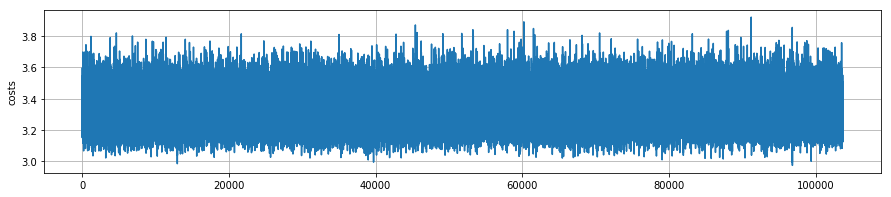

Nearest to <sos>: jptt, ,, from, 跟, 覺得, on, my, 把, 也, !,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 我們, 自己, 對方, 有人,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 亞洲, 大陸, 好萊塢, 可恥,
Nearest to 工作: 薪水, 上班, 公司, 發展, 事情, 交往, 面試, 前景, 會場, 領得,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 覺得, 最愛, 推薦, 想要, 習慣, 愛看,
Nearest to 可以: 能, 可, 要, 不能, 會, 能夠, 還能, 只能, 願意, ok,
Nearest to 約: 円, 南希, 毒龍, 還錢, firefox, 窮, 職業病, 塊, 時辰, 他媽,
Nearest to 電影: 片, 一部, 動畫, 這部, 作品, 小說, 片子, 漫畫, 拍, 發行,
Nearest to 時間: 上菜, 開車, 樂透, 撐過去, 我付, 婚假, 星期一, 中天, 忙, 空虛,
Nearest to 滿足: 小於, 描述, 呷, 樂意, 開說, 幽默, 呼叫, 找間, 溫暖, 精神分裂,
Nearest to 閃光: 男友, 女友, 新車, 射完, 現任, 稱為, 她, 前女友, 合理化, jj,
Nearest to <eos>: xd, sent, !, ?, 嗎, xdd, xddd, from, my, =,

epoch25
Iteration  10371  ( 10.0 %) Train mean loss:  3.3318708  ( std:  0.10632725 ) ; run time:  30 [s]
Iteration  20740  ( 20.0 %) Train mean loss:  3.3320353  ( std:  0.10706479 ) ; run time:  61 [s]
Iteration  31103  ( 30.0 %) Train mean loss:  3.3328626  ( std:  0.107258596 ) ; run time:  91 [s]
Iteration  41474  ( 40.0 %) Tra

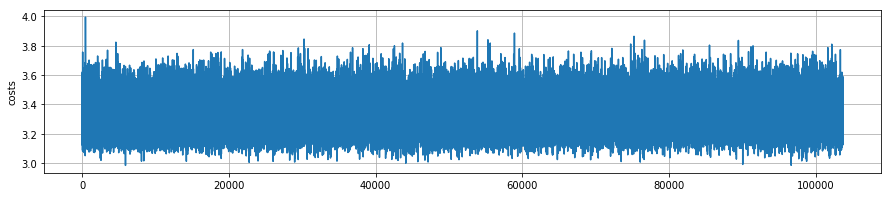

Nearest to <sos>: jptt, ,, from, 覺得, 跟, on, my, 把, 在, 也,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 我們, 自己, 對方, 男友,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 亞洲, 大陸, 產業, 好萊塢,
Nearest to 工作: 薪水, 上班, 公司, 發展, 交往, 事情, 面試, 前景, 會場, 生活,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 覺得, 最愛, 推薦, 想要, 好看, 愛看,
Nearest to 可以: 能, 可, 要, 會, 不能, 能夠, 還能, 只能, 願意, ok,
Nearest to 約: 円, 南希, 還錢, 毒龍, firefox, 窮, 職業病, 會射, 他媽, 時辰,
Nearest to 電影: 片, 一部, 動畫, 這部, 作品, 小說, 片子, 漫畫, 發行, 拍,
Nearest to 時間: 上菜, 開車, 樂透, 撐過去, 星期一, 我付, 中天, 婚假, 忙, 空虛,
Nearest to 滿足: 小於, 描述, 開說, 樂意, 呷, 幽默, 呼叫, 依賴, 溫暖, 找間,
Nearest to 閃光: 男友, 女友, 新車, 射完, 現任, 稱為, 她, 前女友, 合理化, 朋友,
Nearest to <eos>: xd, !, sent, ?, 嗎, xdd, xddd, from, 誤, my,

epoch26
Iteration  10379  ( 10.0 %) Train mean loss:  3.3275476  ( std:  0.107393 ) ; run time:  30 [s]
Iteration  20751  ( 20.0 %) Train mean loss:  3.3285816  ( std:  0.107074 ) ; run time:  61 [s]
Iteration  31120  ( 30.0 %) Train mean loss:  3.3294742  ( std:  0.10742165 ) ; run time:  91 [s]
Iteration  41486  ( 40.0 %) Train mea

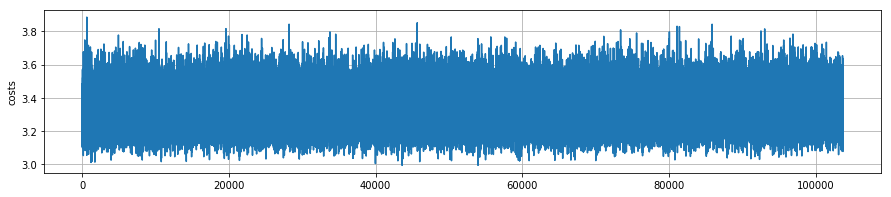

Nearest to <sos>: jptt, ,, from, 覺得, 跟, my, on, 把, 也, !,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 我們, 自己, 對方, 有人,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 亞洲, 產業, 大陸, 好萊塢,
Nearest to 工作: 薪水, 上班, 發展, 公司, 交往, 事情, 面試, 前景, 生活, 矽品,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 覺得, 最愛, 推薦, 想要, 好看, 愛看,
Nearest to 可以: 能, 可, 要, 不能, 會, 能夠, 還能, 只能, 願意, ok,
Nearest to 約: 円, 南希, 還錢, 毒龍, firefox, 職業病, 窮, 猜, 他媽, 時辰,
Nearest to 電影: 片, 一部, 動畫, 作品, 這部, 小說, 片子, 漫畫, 拍, 發行,
Nearest to 時間: 上菜, 開車, 樂透, 撐過去, 星期一, 我付, 婚假, 忙, 中天, 空虛,
Nearest to 滿足: 小於, 開說, 樂意, 描述, 呷, 幽默, 呼叫, 依賴, 溫暖, 找間,
Nearest to 閃光: 男友, 女友, 新車, 射完, 現任, 她, 稱為, 合理化, 前女友, 朋友,
Nearest to <eos>: xd, sent, !, ?, 嗎, xdd, from, xddd, 誤, my,

epoch27
Iteration  10366  ( 10.0 %) Train mean loss:  3.3228908  ( std:  0.10678076 ) ; run time:  31 [s]
Iteration  20729  ( 20.0 %) Train mean loss:  3.325215  ( std:  0.10711593 ) ; run time:  62 [s]
Iteration  31094  ( 30.0 %) Train mean loss:  3.3266332  ( std:  0.1064548 ) ; run time:  93 [s]
Iteration  41460  ( 40.0 %) Train me

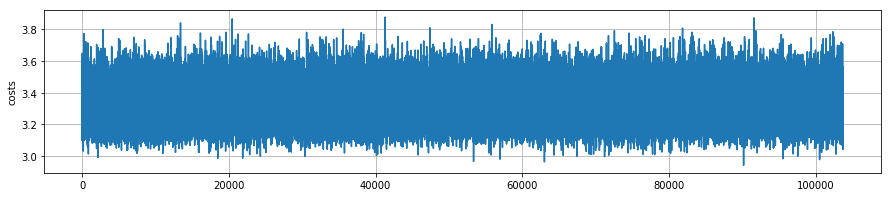

Nearest to <sos>: ,, jptt, from, 跟, 覺得, on, my, 把, 也, !,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 自己, 我們, 對方, 說,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 亞洲, 好萊塢, 大陸, 可恥,
Nearest to 工作: 薪水, 上班, 公司, 發展, 交往, 事情, 面試, 前景, 矽品, 生活,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 覺得, 最愛, 推薦, 想要, 愛看, 習慣,
Nearest to 可以: 能, 可, 要, 不能, 會, 能夠, 還能, 只能, 願意, ok,
Nearest to 約: 円, 南希, 還錢, 毒龍, firefox, 猜, 時辰, 職業病, 他媽, 窮,
Nearest to 電影: 片, 一部, 動畫, 這部, 作品, 小說, 片子, 漫畫, 拍, 發行,
Nearest to 時間: 上菜, 開車, 撐過去, 樂透, 星期一, 我付, 中天, 空虛, 忙, 婚假,
Nearest to 滿足: 小於, 開說, 樂意, 描述, 呷, 幽默, 呼叫, 依賴, 溫暖, 找間,
Nearest to 閃光: 男友, 女友, 新車, 射完, 現任, 她, 稱為, 前女友, 合理化, 朋友,
Nearest to <eos>: xd, sent, !, ?, 嗎, xdd, xddd, from, 誤, =,

epoch28
Iteration  10371  ( 10.0 %) Train mean loss:  3.3223445  ( std:  0.10756002 ) ; run time:  30 [s]
Iteration  20730  ( 20.0 %) Train mean loss:  3.3237474  ( std:  0.1068164 ) ; run time:  60 [s]
Iteration  31095  ( 30.0 %) Train mean loss:  3.324147  ( std:  0.10698518 ) ; run time:  91 [s]
Iteration  41476  ( 40.0 %) Train mean

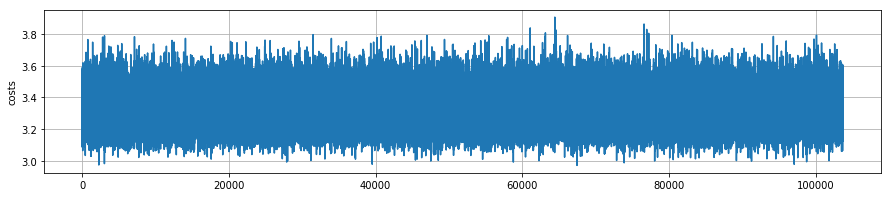

Nearest to <sos>: ,, jptt, from, 覺得, 跟, on, my, 把, !, 也,
Nearest to 我: 他, 你, 她, 妳, 大家, 小弟, 自己, 我們, 對方, 男友,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 亞洲, 大陸, 好萊塢, 產業,
Nearest to 工作: 上班, 薪水, 公司, 發展, 事情, 交往, 面試, 矽品, 前景, 傳產,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 推薦, 覺得, 愛看, 想要, 習慣,
Nearest to 可以: 能, 可, 要, 不能, 能夠, 會, 還能, 只能, 願意, ok,
Nearest to 約: 円, 南希, 還錢, 毒龍, firefox, 猜, 職業病, 他媽, 窮, 時辰,
Nearest to 電影: 片, 一部, 動畫, 這部, 作品, 小說, 片子, 漫畫, 拍, 發行,
Nearest to 時間: 上菜, 樂透, 撐過去, 開車, 星期一, 空虛, 我付, 中天, 忙, 婚假,
Nearest to 滿足: 小於, 開說, 樂意, 描述, 呷, 幽默, 呼叫, 溫暖, 依賴, 找間,
Nearest to 閃光: 男友, 女友, 新車, 射完, 現任, 她, 稱為, 前女友, 合理化, 倫理,
Nearest to <eos>: xd, sent, !, ?, 嗎, xdd, xddd, from, 誤, my,

epoch29
Iteration  10373  ( 10.0 %) Train mean loss:  3.3202646  ( std:  0.10624665 ) ; run time:  30 [s]
Iteration  20739  ( 20.0 %) Train mean loss:  3.3216646  ( std:  0.10659064 ) ; run time:  60 [s]
Iteration  31113  ( 30.0 %) Train mean loss:  3.322489  ( std:  0.10670385 ) ; run time:  91 [s]
Iteration  41478  ( 40.0 %) Train m

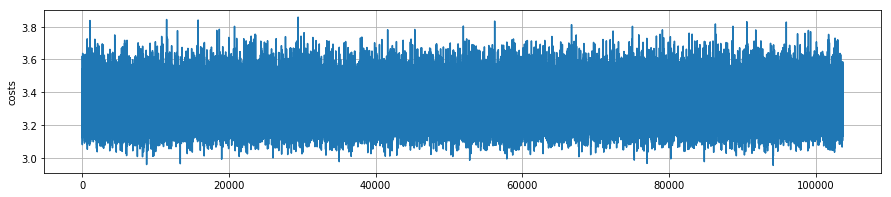

Nearest to <sos>: ,, jptt, from, 跟, on, 覺得, my, 把, 也, !,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 自己, 我們, 說, 對方,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 亞洲, 大陸, 好萊塢, 產業,
Nearest to 工作: 上班, 薪水, 發展, 公司, 交往, 事情, 前景, 面試, 矽品, 生活,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 推薦, 覺得, 愛看, 想要, 習慣,
Nearest to 可以: 能, 可, 要, 不能, 會, 能夠, 還能, 願意, ok, 只能,
Nearest to 約: 円, 南希, 還錢, 猜, 毒龍, firefox, 他媽, 窮, 職業病, 14,
Nearest to 電影: 片, 一部, 動畫, 這部, 作品, 片子, 小說, 漫畫, 發行, 拍,
Nearest to 時間: 上菜, 撐過去, 樂透, 星期一, 開車, 空虛, 我付, 忙, 中天, 龍貓,
Nearest to 滿足: 小於, 開說, 樂意, 描述, 呷, 幽默, 呼叫, 溫暖, 依賴, 嘞,
Nearest to 閃光: 男友, 女友, 新車, 射完, 現任, 她, 前女友, 稱為, 合理化, 倫理,
Nearest to <eos>: xd, sent, !, ?, 嗎, xdd, xddd, from, 誤, my,

epoch30
Iteration  10378  ( 10.0 %) Train mean loss:  3.3188972  ( std:  0.10570361 ) ; run time:  30 [s]
Iteration  20753  ( 20.0 %) Train mean loss:  3.3193872  ( std:  0.106420256 ) ; run time:  61 [s]
Iteration  31120  ( 30.0 %) Train mean loss:  3.3202324  ( std:  0.10623837 ) ; run time:  91 [s]
Iteration  41493  ( 40.0 %) Train m

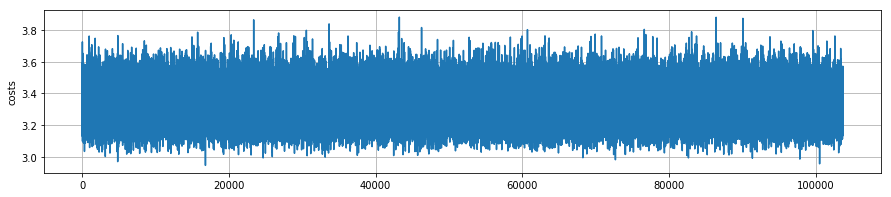

Nearest to <sos>: ,, jptt, from, 跟, 覺得, on, my, 把, 也, 在,
Nearest to 我: 你, 他, 她, 妳, 小弟, 大家, 自己, 我們, 對方, 這我,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 亞洲, 大陸, 產業, 好萊塢,
Nearest to 工作: 上班, 薪水, 發展, 公司, 交往, 事情, 矽品, 前景, 面試, 生活,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 推薦, 覺得, 想要, 愛看, 熱愛,
Nearest to 可以: 能, 可, 要, 不能, 能夠, 會, 還能, 願意, 只能, ok,
Nearest to 約: 円, 南希, 猜, 還錢, 毒龍, firefox, 職業病, 他媽, 表妹, 窮,
Nearest to 電影: 片, 一部, 動畫, 這部, 作品, 片子, 小說, 漫畫, 發行, 拍,
Nearest to 時間: 上菜, 撐過去, 樂透, 星期一, 開車, 空虛, 中天, 忙, 我付, 龍貓,
Nearest to 滿足: 小於, 開說, 樂意, 描述, 幽默, 呷, 呼叫, 溫暖, 依賴, 嘞,
Nearest to 閃光: 男友, 女友, 新車, 射完, 現任, 她, 前女友, 稱為, 合理化, 倫理,
Nearest to <eos>: xd, sent, !, ?, 嗎, from, xdd, xddd, 誤, my,

epoch31
Iteration  10370  ( 10.0 %) Train mean loss:  3.3161395  ( std:  0.105857514 ) ; run time:  30 [s]
Iteration  20736  ( 20.0 %) Train mean loss:  3.3176963  ( std:  0.10517437 ) ; run time:  61 [s]
Iteration  31109  ( 30.0 %) Train mean loss:  3.3178177  ( std:  0.10532461 ) ; run time:  91 [s]
Iteration  41470  ( 40.0 %) Train 

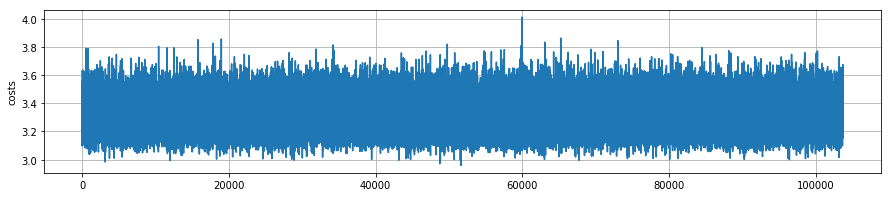

Nearest to <sos>: jptt, ,, from, 覺得, 跟, on, my, !, 把, 也,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 自己, 我們, 對方, 人,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 亞洲, 大陸, 好萊塢, 產業,
Nearest to 工作: 上班, 薪水, 發展, 公司, 交往, 事情, 前景, 矽品, 面試, 生活,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 推薦, 覺得, 想要, 愛看, 熱愛,
Nearest to 可以: 能, 可, 要, 不能, 能夠, 會, 還能, 只能, 願意, ok,
Nearest to 約: 円, 南希, 猜, 還錢, firefox, 毒龍, 職業病, 他媽, 表妹, 窮,
Nearest to 電影: 片, 一部, 動畫, 這部, 作品, 小說, 片子, 漫畫, 拍, 發行,
Nearest to 時間: 上菜, 樂透, 撐過去, 星期一, 空虛, 中天, 開車, 忙, 我付, 龍貓,
Nearest to 滿足: 小於, 開說, 樂意, 幽默, 呷, 描述, 呼叫, 溫暖, 嘞, 依賴,
Nearest to 閃光: 男友, 女友, 新車, 射完, 現任, 她, 前女友, 合理化, 稱為, 倫理,
Nearest to <eos>: xd, sent, !, ?, 嗎, from, xdd, xddd, 誤, my,

epoch32
Iteration  10366  ( 10.0 %) Train mean loss:  3.3135502  ( std:  0.10640496 ) ; run time:  32 [s]
Iteration  20734  ( 20.0 %) Train mean loss:  3.3144689  ( std:  0.10603268 ) ; run time:  63 [s]
Iteration  31096  ( 30.0 %) Train mean loss:  3.315473  ( std:  0.10573823 ) ; run time:  93 [s]
Iteration  41458  ( 40.0 %) Train mea

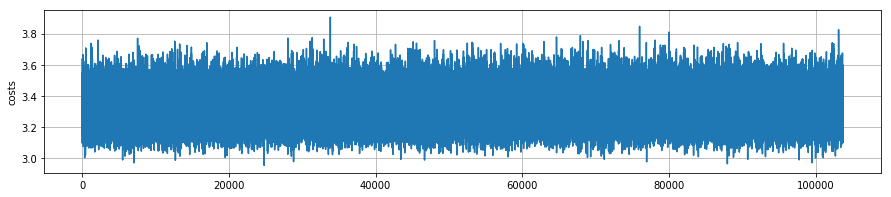

Nearest to <sos>: jptt, ,, from, 跟, my, 覺得, on, 把, !, 在,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 我們, 自己, 對方, 這我,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 大陸, 亞洲, 好萊塢, 可恥,
Nearest to 工作: 上班, 薪水, 發展, 公司, 矽品, 交往, 事情, 前景, 面試, 生活,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 覺得, 推薦, 想要, 愛看, 習慣,
Nearest to 可以: 能, 可, 要, 不能, 會, 能夠, 還能, 只能, ok, 願意,
Nearest to 約: 円, 猜, 還錢, 南希, 毒龍, firefox, 他媽, 職業病, 表妹, 窮,
Nearest to 電影: 片, 一部, 動畫, 這部, 作品, 片子, 小說, 漫畫, 發行, 拍,
Nearest to 時間: 上菜, 樂透, 撐過去, 星期一, 空虛, 開車, 中天, 忙, 我付, 龍貓,
Nearest to 滿足: 小於, 開說, 樂意, 幽默, 呷, 呼叫, 溫暖, 描述, 嘞, 依賴,
Nearest to 閃光: 男友, 女友, 新車, 射完, 現任, 她, 前女友, 合理化, 朋友, 稱為,
Nearest to <eos>: xd, sent, !, ?, 嗎, xdd, from, xddd, 誤, my,

epoch33
Iteration  10375  ( 10.0 %) Train mean loss:  3.3110466  ( std:  0.104599126 ) ; run time:  30 [s]
Iteration  20758  ( 20.0 %) Train mean loss:  3.3121078  ( std:  0.104775995 ) ; run time:  61 [s]
Iteration  31123  ( 30.0 %) Train mean loss:  3.3131883  ( std:  0.10502496 ) ; run time:  91 [s]
Iteration  41492  ( 40.0 %) Train

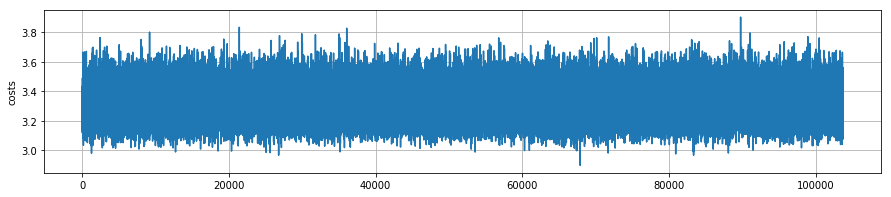

Nearest to <sos>: ,, jptt, from, 跟, 覺得, my, on, 把, !, 在,
Nearest to 我: 你, 他, 她, 妳, 小弟, 大家, 自己, 我們, 對方, 人,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 亞洲, 大陸, 好萊塢, 產業,
Nearest to 工作: 上班, 薪水, 發展, 公司, 交往, 矽品, 前景, 事情, 面試, 生活,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 覺得, 推薦, 愛看, 想要, 熱愛,
Nearest to 可以: 能, 可, 要, 不能, 能夠, 會, 還能, 願意, 只能, ok,
Nearest to 約: 円, 猜, 還錢, 南希, 毒龍, 職業病, 他媽, firefox, 表妹, 窮,
Nearest to 電影: 片, 一部, 動畫, 這部, 片子, 作品, 小說, 漫畫, 發行, 拍,
Nearest to 時間: 上菜, 樂透, 星期一, 撐過去, 空虛, 忙, 開車, 中天, 我付, 龍貓,
Nearest to 滿足: 小於, 開說, 樂意, 幽默, 溫暖, 呼叫, 嘞, 呷, 描述, 依賴,
Nearest to 閃光: 男友, 女友, 新車, 現任, 射完, 她, 前女友, 合理化, 稱為, jj,
Nearest to <eos>: xd, sent, !, ?, 嗎, from, xdd, 誤, xddd, my,

epoch34
Iteration  10373  ( 10.0 %) Train mean loss:  3.31031  ( std:  0.104917504 ) ; run time:  30 [s]
Iteration  20747  ( 20.0 %) Train mean loss:  3.3109772  ( std:  0.10545062 ) ; run time:  60 [s]
Iteration  31118  ( 30.0 %) Train mean loss:  3.3117936  ( std:  0.105101965 ) ; run time:  91 [s]
Iteration  41490  ( 40.0 %) Train me

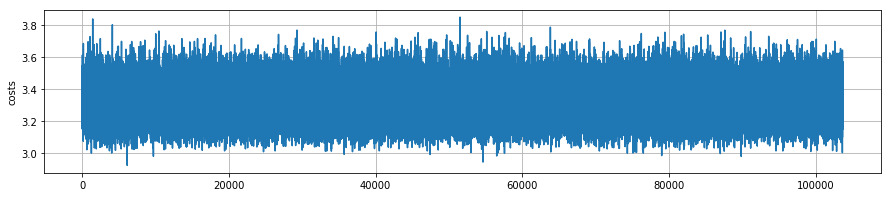

Nearest to <sos>: ,, jptt, from, 跟, 覺得, on, my, 把, !, 也,
Nearest to 我: 你, 他, 她, 妳, 小弟, 大家, 自己, 我們, 對方, 人,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 亞洲, 大陸, 好萊塢, 可恥,
Nearest to 工作: 上班, 薪水, 發展, 公司, 交往, 矽品, 事情, 面試, 生活, 前景,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 覺得, 愛看, 推薦, 熱愛, 習慣,
Nearest to 可以: 能, 可, 要, 不能, 能夠, 會, 還能, ok, 願意, 只能,
Nearest to 約: 円, 猜, 還錢, 南希, 職業病, 毒龍, 他媽, 表妹, firefox, 聊,
Nearest to 電影: 片, 一部, 動畫, 作品, 這部, 片子, 小說, 漫畫, 拍, 發行,
Nearest to 時間: 上菜, 樂透, 空虛, 星期一, 撐過去, 忙, 開車, 中天, 我付, 龍貓,
Nearest to 滿足: 小於, 開說, 樂意, 幽默, 嘞, 溫暖, 呼叫, 呷, 描述, 享受,
Nearest to 閃光: 男友, 女友, 新車, 現任, 射完, 前女友, 她, 合理化, 朋友, 倫理,
Nearest to <eos>: xd, sent, !, ?, 嗎, xdd, 誤, from, xddd, my,

epoch35
Iteration  10360  ( 10.0 %) Train mean loss:  3.3092303  ( std:  0.10533016 ) ; run time:  30 [s]
Iteration  20734  ( 20.0 %) Train mean loss:  3.3100057  ( std:  0.105310135 ) ; run time:  61 [s]
Iteration  31106  ( 30.0 %) Train mean loss:  3.3107128  ( std:  0.105308 ) ; run time:  92 [s]
Iteration  41477  ( 40.0 %) Train mea

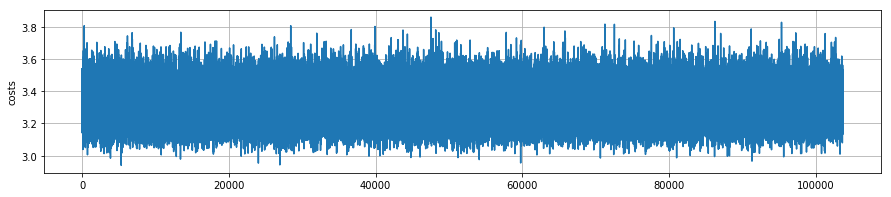

Nearest to <sos>: ,, jptt, from, 跟, on, my, 覺得, 把, !, 純噓,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 我們, 自己, 本魯, 對方,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 大陸, 亞洲, 好萊塢, 產業,
Nearest to 工作: 上班, 薪水, 發展, 公司, 交往, 矽品, 事情, 生活, 前景, 面試,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 覺得, 愛看, 推薦, 熱愛, 習慣,
Nearest to 可以: 能, 可, 要, 不能, 能夠, 會, 還能, 願意, ok, 只能,
Nearest to 約: 円, 猜, 南希, 還錢, 職業病, 毒龍, 表妹, 他媽, firefox, 死死的,
Nearest to 電影: 片, 動畫, 一部, 這部, 作品, 片子, 小說, 漫畫, 發行, 拍,
Nearest to 時間: 上菜, 星期一, 樂透, 空虛, 忙, 撐過去, 中天, 開車, 我付, 龍貓,
Nearest to 滿足: 小於, 開說, 樂意, 嘞, 幽默, 溫暖, 呼叫, 呷, 描述, 早點,
Nearest to 閃光: 男友, 女友, 新車, 現任, 射完, 前女友, 她, 合理化, 朋友, 倫理,
Nearest to <eos>: xd, sent, !, ?, 嗎, xdd, 誤, from, xddd, my,

epoch36
Iteration  10372  ( 10.0 %) Train mean loss:  3.3051455  ( std:  0.10457625 ) ; run time:  30 [s]
Iteration  20736  ( 20.0 %) Train mean loss:  3.3066537  ( std:  0.10478029 ) ; run time:  60 [s]
Iteration  31114  ( 30.0 %) Train mean loss:  3.3076665  ( std:  0.10453761 ) ; run time:  91 [s]
Iteration  41492  ( 40.0 %) Trai

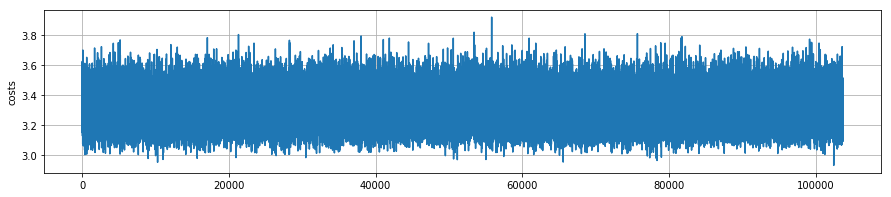

Nearest to <sos>: ,, jptt, from, 覺得, 跟, on, my, 把, !, 在,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 我們, 自己, 對方, 本魯,
Nearest to 台灣: 日本, 中國, 臺灣, 美國, yahoo, 韓國, 大陸, 亞洲, 好萊塢, 可恥,
Nearest to 工作: 薪水, 上班, 發展, 交往, 公司, 矽品, 前景, 事情, 領得, 生活,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 覺得, 愛看, 推薦, 熱愛, 想要,
Nearest to 可以: 能, 可, 要, 能夠, 不能, 還能, 會, 願意, ok, 只能,
Nearest to 約: 円, 猜, 還錢, 南希, 職業病, 表妹, firefox, 死死的, 毒龍, 聊,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 小說, 漫畫, 發行, 拍,
Nearest to 時間: 上菜, 星期一, 空虛, 樂透, 撐過去, 忙, 中天, 開車, 我付, 龍貓,
Nearest to 滿足: 小於, 開說, 樂意, 幽默, 嘞, 溫暖, 呼叫, 呷, 早點, 描述,
Nearest to 閃光: 男友, 女友, 現任, 新車, 射完, 前女友, 她, 合理化, 朋友, 倫理,
Nearest to <eos>: xd, sent, !, ?, 嗎, xdd, from, 誤, xddd, my,

epoch37
Iteration  10365  ( 10.0 %) Train mean loss:  3.3045387  ( std:  0.10314024 ) ; run time:  30 [s]
Iteration  20745  ( 20.0 %) Train mean loss:  3.3050053  ( std:  0.10462014 ) ; run time:  61 [s]
Iteration  31113  ( 30.0 %) Train mean loss:  3.3058171  ( std:  0.10489358 ) ; run time:  91 [s]
Iteration  41483  ( 40.0 %) Train 

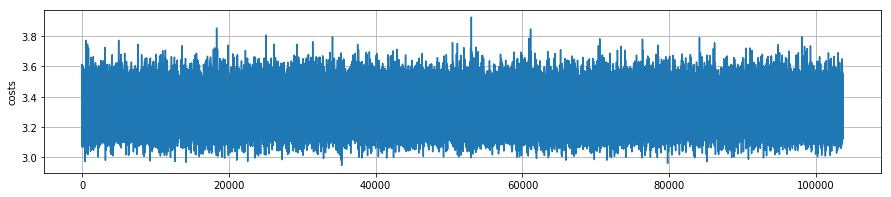

Nearest to <sos>: ,, jptt, from, 跟, 覺得, on, my, 把, !, 如題,
Nearest to 我: 你, 他, 她, 妳, 小弟, 大家, 自己, 我們, 這我, 本魯,
Nearest to 台灣: 日本, 臺灣, 中國, 美國, yahoo, 韓國, 亞洲, 大陸, 產業, 好萊塢,
Nearest to 工作: 上班, 薪水, 發展, 公司, 交往, 矽品, 面試, 前景, 應徵, 事情,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 覺得, 愛看, 推薦, 熱愛, 想要,
Nearest to 可以: 能, 可, 要, 能夠, 不能, 會, 還能, 願意, ok, 只能,
Nearest to 約: 円, 猜, 還錢, 南希, 表妹, 職業病, 毒龍, 死死的, 聊, firefox,
Nearest to 電影: 片, 一部, 動畫, 片子, 作品, 這部, 小說, 漫畫, 發行, 拍,
Nearest to 時間: 上菜, 星期一, 空虛, 樂透, 忙, 撐過去, 中天, 開車, 龍貓, 我付,
Nearest to 滿足: 小於, 開說, 樂意, 嘞, 溫暖, 呼叫, 幽默, 享受, 早點, 自律,
Nearest to 閃光: 男友, 女友, 現任, 新車, 射完, 她, 前女友, 合理化, 倫理, 朋友,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xdd, xddd, my,

epoch38
Iteration  10375  ( 10.0 %) Train mean loss:  3.3046148  ( std:  0.10404205 ) ; run time:  31 [s]
Iteration  20747  ( 20.0 %) Train mean loss:  3.3042748  ( std:  0.10347093 ) ; run time:  66 [s]
Iteration  31116  ( 30.0 %) Train mean loss:  3.3046837  ( std:  0.10342393 ) ; run time:  97 [s]
Iteration  41487  ( 40.0 %) Trai

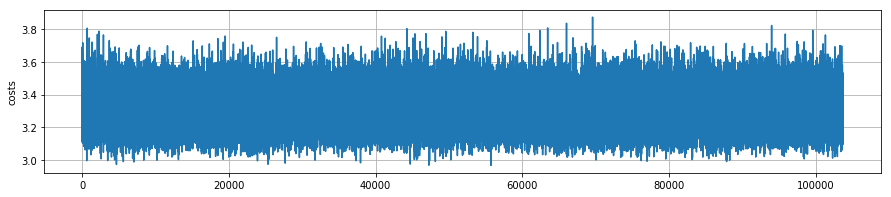

Nearest to <sos>: ,, jptt, from, 跟, 覺得, on, my, 把, !, 在,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 我們, 自己, 對方, 這我,
Nearest to 台灣: 日本, 臺灣, 中國, 美國, yahoo, 韓國, 亞洲, 大陸, 好萊塢, 產業,
Nearest to 工作: 上班, 薪水, 發展, 公司, 交往, 矽品, 前景, 面試, 應徵, 研究所,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 覺得, 愛看, 推薦, 熱愛, 想要,
Nearest to 可以: 能, 可, 要, 能夠, 不能, 還能, 會, 願意, 只能, ok,
Nearest to 約: 円, 猜, 還錢, 南希, 表妹, 毒龍, 職業病, 死死的, firefox, 聊,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 小說, 漫畫, 發行, 拍,
Nearest to 時間: 上菜, 星期一, 空虛, 樂透, 撐過去, 忙, 中天, 龍貓, 開車, 我付,
Nearest to 滿足: 小於, 開說, 嘞, 樂意, 幽默, 呼叫, 溫暖, 早點, 享受, 自律,
Nearest to 閃光: 男友, 女友, 現任, 新車, 射完, 她, 前女友, 合理化, 倫理, 女朋友,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xdd, xddd, my,

epoch39
Iteration  10373  ( 10.0 %) Train mean loss:  3.302445  ( std:  0.10344942 ) ; run time:  30 [s]
Iteration  20755  ( 20.0 %) Train mean loss:  3.3019736  ( std:  0.10410739 ) ; run time:  61 [s]
Iteration  31124  ( 30.0 %) Train mean loss:  3.3018556  ( std:  0.10397965 ) ; run time:  91 [s]
Iteration  41495  ( 40.0 %) Trai

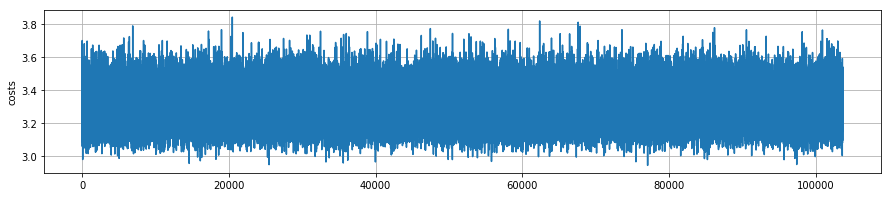

Nearest to <sos>: ,, jptt, from, 跟, on, 覺得, my, !, 把, 也,
Nearest to 我: 你, 他, 她, 妳, 小弟, 大家, 我們, 自己, 本魯, .我,
Nearest to 台灣: 臺灣, 日本, 中國, 美國, yahoo, 韓國, 亞洲, 大陸, 好萊塢, 產業,
Nearest to 工作: 上班, 薪水, 發展, 公司, 交往, 矽品, 研究所, 前景, 傳產, 領得,
Nearest to 喜歡: 討厭, 愛, 超愛, 適合, 最愛, 覺得, 愛看, 熱愛, 推薦, 想要,
Nearest to 可以: 能, 可, 要, 能夠, 還能, 不能, 會, 願意, ok, 只能,
Nearest to 約: 猜, 円, 還錢, 南希, 表妹, 死死的, 職業病, firefox, 毒龍, 搭訕,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 小說, 漫畫, 發行, 商業片,
Nearest to 時間: 上菜, 空虛, 星期一, 樂透, 撐過去, 忙, 中天, 龍貓, 開車, 家務事,
Nearest to 滿足: 小於, 開說, 嘞, 呼叫, 樂意, 溫暖, 幽默, 早點, 自律, 享受,
Nearest to 閃光: 男友, 女友, 現任, 新車, 射完, 她, 前女友, 合理化, 倫理, 朋友,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xdd, xddd, my,

epoch40
Iteration  10378  ( 10.0 %) Train mean loss:  3.2995203  ( std:  0.10369987 ) ; run time:  30 [s]
Iteration  20745  ( 20.0 %) Train mean loss:  3.3001149  ( std:  0.10364478 ) ; run time:  60 [s]
Iteration  31114  ( 30.0 %) Train mean loss:  3.3008535  ( std:  0.10393596 ) ; run time:  91 [s]
Iteration  41488  ( 40.0 %) 

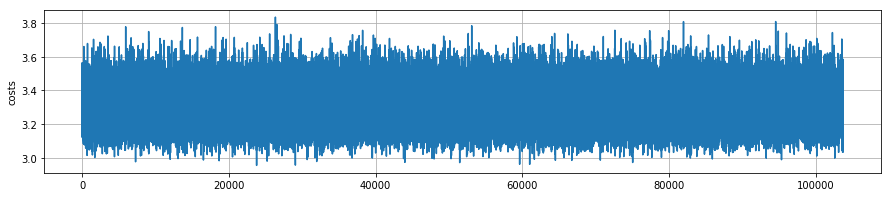

Nearest to <sos>: ,, jptt, from, 跟, on, 覺得, my, !, 把, 純噓,
Nearest to 我: 你, 他, 她, 妳, 小弟, 大家, 我們, 自己, 本魯, 人,
Nearest to 台灣: 臺灣, 日本, 中國, 美國, 韓國, yahoo, 亞洲, 大陸, 好萊塢, 產業,
Nearest to 工作: 上班, 薪水, 發展, 公司, 矽品, 交往, 研究所, 應徵, 單位, 傳產,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 覺得, 愛看, 熱愛, 想要, 習慣,
Nearest to 可以: 能, 可, 要, 能夠, 會, 還能, 不能, 願意, ok, 只能,
Nearest to 約: 猜, 円, 還錢, 南希, 表妹, 死死的, 職業病, firefox, 搭訕, 單獨,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 小說, 漫畫, 發行, 國片,
Nearest to 時間: 上菜, 空虛, 星期一, 樂透, 撐過去, 忙, 中天, 龍貓, 開車, 家務事,
Nearest to 滿足: 小於, 開說, 嘞, 樂意, 呼叫, 幽默, 溫暖, 早點, 自律, 享受,
Nearest to 閃光: 男友, 女友, 現任, 新車, 射完, 前女友, 她, 合理化, 倫理, 女朋友,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xdd, xddd, my,

epoch41
Iteration  10374  ( 10.0 %) Train mean loss:  3.2970858  ( std:  0.10387266 ) ; run time:  30 [s]
Iteration  20746  ( 20.0 %) Train mean loss:  3.2975314  ( std:  0.103756644 ) ; run time:  61 [s]
Iteration  31115  ( 30.0 %) Train mean loss:  3.2986815  ( std:  0.103513435 ) ; run time:  91 [s]
Iteration  41489  ( 40.0 %

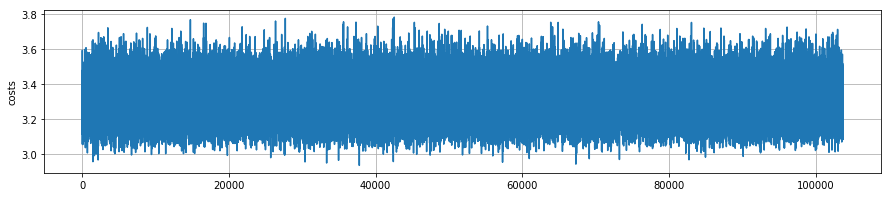

Nearest to <sos>: ,, jptt, from, 跟, 覺得, on, !, 把, my, 在,
Nearest to 我: 你, 他, 她, 妳, 小弟, 我們, 大家, 自己, 對方, 本魯,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, 美國, yahoo, 亞洲, 大陸, 產業, 好萊塢,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 公司, 交往, 傳產, 單位, 研究所, 生活,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 愛看, 覺得, 熱愛, 習慣, 推薦,
Nearest to 可以: 能, 可, 要, 能夠, 還能, 不能, 會, 願意, ok, 只能,
Nearest to 約: 猜, 円, 還錢, 南希, 表妹, 搭訕, 死死的, 單獨, 毒龍, firefox,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 小說, 漫畫, 發行, 國片,
Nearest to 時間: 上菜, 空虛, 星期一, 樂透, 撐過去, 忙, 中天, 龍貓, 家務事, 怪人,
Nearest to 滿足: 小於, 開說, 嘞, 早點, 呼叫, 樂意, 溫暖, 幽默, 享受, 自律,
Nearest to 閃光: 男友, 女友, 現任, 新車, 射完, 前女友, 她, 合理化, 倫理, 女朋友,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xdd, xddd, =,

epoch42
Iteration  10367  ( 10.0 %) Train mean loss:  3.2976701  ( std:  0.10331915 ) ; run time:  30 [s]
Iteration  20741  ( 20.0 %) Train mean loss:  3.2974844  ( std:  0.10413614 ) ; run time:  60 [s]
Iteration  31106  ( 30.0 %) Train mean loss:  3.2980437  ( std:  0.10392009 ) ; run time:  91 [s]
Iteration  41470  ( 40.0 %) Tr

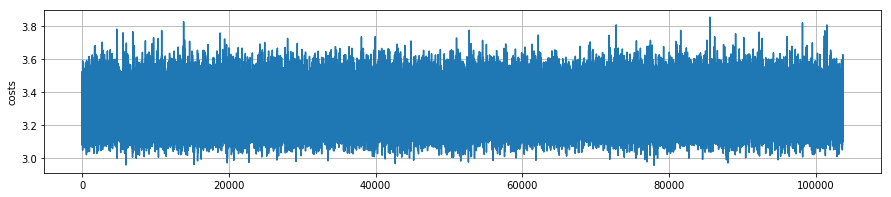

Nearest to <sos>: ,, jptt, from, 跟, on, 覺得, my, !, 把, 也,
Nearest to 我: 你, 他, 她, 妳, 小弟, 大家, 自己, 我們, 人, 這我,
Nearest to 台灣: 臺灣, 日本, 中國, yahoo, 韓國, 美國, 亞洲, 大陸, 產業, 好萊塢,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 公司, 交往, 單位, 傳產, 研究所, 發展性,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 覺得, 熱愛, 愛看, 習慣, 想要,
Nearest to 可以: 能, 可, 要, 能夠, 會, 還能, 不能, ok, 願意, 只能,
Nearest to 約: 猜, 円, 南希, 還錢, 表妹, 搭訕, firefox, 死死的, 職業病, 毒龍,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 漫畫, 小說, 發行, 國片,
Nearest to 時間: 上菜, 空虛, 星期一, 樂透, 撐過去, 忙, 中天, 家務事, 龍貓, 怪人,
Nearest to 滿足: 小於, 開說, 嘞, 早點, 樂意, 呼叫, 溫暖, 幽默, 自律, 享受,
Nearest to 閃光: 男友, 女友, 現任, 新車, 射完, 她, 前女友, 合理化, 女朋友, 倫理,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, xdd, from, xddd, my,

epoch43
Iteration  10368  ( 10.0 %) Train mean loss:  3.294714  ( std:  0.102809556 ) ; run time:  30 [s]
Iteration  20739  ( 20.0 %) Train mean loss:  3.2957313  ( std:  0.10376968 ) ; run time:  60 [s]
Iteration  31105  ( 30.0 %) Train mean loss:  3.2960398  ( std:  0.1038677 ) ; run time:  91 [s]
Iteration  41468  ( 40.0 %) T

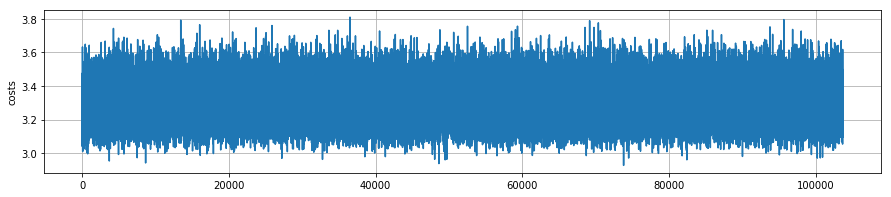

Nearest to <sos>: ,, jptt, from, 跟, 覺得, on, my, !, 把, 如題,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 自己, 我們, 這我, 本魯,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 美國, 亞洲, 大陸, 好萊塢, 產業,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 公司, 交往, 單位, 傳產, 發展性, 應徵,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 覺得, 愛看, 熱愛, 想要, 習慣,
Nearest to 可以: 能, 可, 要, 能夠, 還能, 不能, 會, ok, 願意, 只能,
Nearest to 約: 猜, 円, 南希, 還錢, 搭訕, 表妹, 死死的, 約會, 單獨, firefox,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 漫畫, 小說, 發行, 國片,
Nearest to 時間: 上菜, 空虛, 星期一, 樂透, 撐過去, 忙, 中天, 阿波, 家務事, 開車,
Nearest to 滿足: 小於, 開說, 嘞, 早點, 呼叫, 樂意, 溫暖, 幽默, 自律, 享受,
Nearest to 閃光: 男友, 女友, 現任, 新車, 射完, 前女友, 她, 合理化, 女朋友, 倫理,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xdd, xddd, my,

epoch44
Iteration  10375  ( 10.0 %) Train mean loss:  3.2938595  ( std:  0.10313751 ) ; run time:  30 [s]
Iteration  20751  ( 20.0 %) Train mean loss:  3.2945755  ( std:  0.103388116 ) ; run time:  60 [s]
Iteration  31112  ( 30.0 %) Train mean loss:  3.2943418  ( std:  0.10386485 ) ; run time:  90 [s]
Iteration  41479  ( 40.0 %)

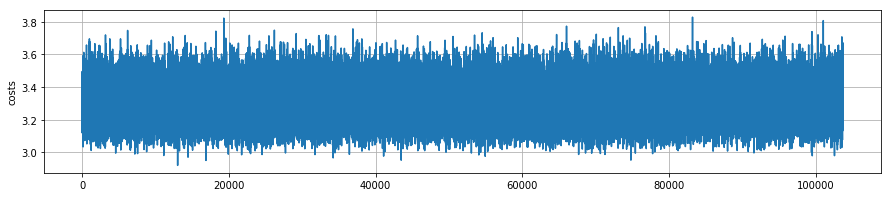

Nearest to <sos>: ,, jptt, from, 跟, 覺得, on, 把, my, !, 如題,
Nearest to 我: 你, 他, 她, 妳, 小弟, 我們, 大家, 自己, .我, 這我,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 美國, 亞洲, 大陸, 產業, 好萊塢,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 交往, 公司, 單位, 應徵, 研究所, 領得,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 熱愛, 愛看, 覺得, 習慣, 想要,
Nearest to 可以: 能, 可, 要, 能夠, 還能, 會, 不能, 願意, ok, 只能,
Nearest to 約: 猜, 円, 還錢, 南希, 搭訕, 表妹, 單獨, 死死的, 外縣市, 交,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 小說, 漫畫, 發行, 國片,
Nearest to 時間: 上菜, 空虛, 星期一, 樂透, 撐過去, 忙, 中天, 家務事, 龍貓, 阿波,
Nearest to 滿足: 小於, 開說, 嘞, 早點, 呼叫, 樂意, 溫暖, 自律, 幽默, 享受,
Nearest to 閃光: 男友, 女友, 現任, 新車, 射完, 前女友, 她, 合理化, 倫理, 朋友,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xdd, xddd, my,

epoch45
Iteration  10370  ( 10.0 %) Train mean loss:  3.2917147  ( std:  0.10377154 ) ; run time:  34 [s]
Iteration  20731  ( 20.0 %) Train mean loss:  3.2924979  ( std:  0.10322504 ) ; run time:  65 [s]
Iteration  31103  ( 30.0 %) Train mean loss:  3.2932732  ( std:  0.10303282 ) ; run time:  96 [s]
Iteration  41467  ( 40.0 %) Train 

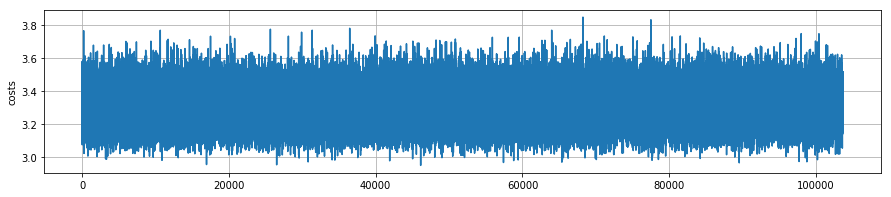

Nearest to <sos>: ,, jptt, from, 跟, on, 覺得, !, my, 把, 如題,
Nearest to 我: 你, 他, 她, 妳, 小弟, 大家, 我們, .我, 這我, 自己,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 亞洲, 美國, 大陸, 可恥, 產業,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 公司, 交往, 單位, 研究所, 發展性, 應徵,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 熱愛, 覺得, 愛看, 推薦, 想要,
Nearest to 可以: 能, 可, 要, 能夠, 還能, 會, 不能, 願意, ok, 只能,
Nearest to 約: 猜, 円, 南希, 還錢, 搭訕, 表妹, 約會, 單獨, 死死的, 職業病,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 漫畫, 小說, 商業片, 發行,
Nearest to 時間: 上菜, 空虛, 星期一, 樂透, 忙, 撐過去, 中天, 龍貓, 怪人, 家務事,
Nearest to 滿足: 小於, 開說, 嘞, 早點, 樂意, 呼叫, 溫暖, 自律, 幽默, 享受,
Nearest to 閃光: 男友, 女友, 現任, 新車, 射完, 前女友, 她, 合理化, 女朋友, 倫理,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xddd, xdd, posted,

epoch46
Iteration  10372  ( 10.0 %) Train mean loss:  3.2909722  ( std:  0.10412974 ) ; run time:  31 [s]
Iteration  20742  ( 20.0 %) Train mean loss:  3.2909381  ( std:  0.103995286 ) ; run time:  62 [s]
Iteration  31109  ( 30.0 %) Train mean loss:  3.291669  ( std:  0.10361975 ) ; run time:  92 [s]
Iteration  41485  ( 40.0 %)

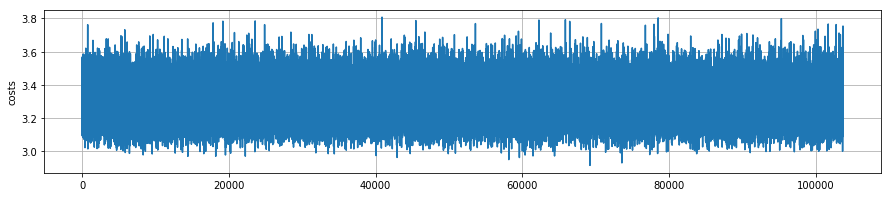

Nearest to <sos>: ,, jptt, from, 跟, on, 覺得, !, my, 把, 如題,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 我們, 自己, 本魯, 這我,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 美國, 亞洲, 大陸, 產業, 可恥,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 交往, 單位, 公司, 應徵, 發展性, 研究所,
Nearest to 喜歡: 討厭, 愛, 超愛, 適合, 最愛, 熱愛, 愛看, 覺得, 推薦, 習慣,
Nearest to 可以: 能, 可, 要, 能夠, 還能, 會, 不能, 願意, ok, 只能,
Nearest to 約: 猜, 円, 南希, 還錢, 表妹, 搭訕, 約會, 死死的, 單獨, 炫耀,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 漫畫, 小說, 國片, 發行,
Nearest to 時間: 上菜, 星期一, 空虛, 樂透, 撐過去, 忙, 中天, 龍貓, 阿波, 家務事,
Nearest to 滿足: 小於, 開說, 嘞, 早點, 樂意, 呼叫, 自律, 溫暖, 幽默, 感觸,
Nearest to 閃光: 男友, 女友, 現任, 新車, 射完, 前女友, 她, 合理化, 女朋友, 朋友,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xddd, xdd, ,,

epoch47
Iteration  10365  ( 10.0 %) Train mean loss:  3.2903593  ( std:  0.10340512 ) ; run time:  30 [s]
Iteration  20736  ( 20.0 %) Train mean loss:  3.2904727  ( std:  0.103498906 ) ; run time:  60 [s]
Iteration  31115  ( 30.0 %) Train mean loss:  3.2905767  ( std:  0.10371575 ) ; run time:  90 [s]
Iteration  41480  ( 40.0 %) Train

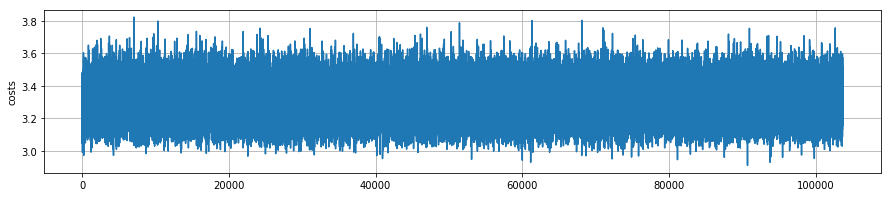

Nearest to <sos>: ,, jptt, from, 跟, on, 覺得, !, my, 把, 如題,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 自己, 我們, 本魯, 這我,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 亞洲, 美國, 大陸, 可恥, 產業,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 公司, 交往, 單位, 發展性, 應徵, 研究所,
Nearest to 喜歡: 討厭, 愛, 超愛, 適合, 最愛, 熱愛, 愛看, 覺得, 推薦, 習慣,
Nearest to 可以: 能, 可, 要, 能夠, 還能, 不能, 會, 願意, ok, 只能,
Nearest to 約: 猜, 円, 南希, 還錢, 搭訕, 表妹, 約會, 單獨, 死死的, 交,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 小說, 漫畫, 發行, 國片,
Nearest to 時間: 上菜, 星期一, 空虛, 樂透, 忙, 撐過去, 中天, 看錢, 阿波, 龍貓,
Nearest to 滿足: 開說, 小於, 嘞, 早點, 樂意, 自律, 呼叫, 溫暖, 獲得, 幽默,
Nearest to 閃光: 男友, 女友, 現任, 新車, 射完, 前女友, 女朋友, 合理化, 她, 倫理,
Nearest to <eos>: xd, sent, ?, !, 嗎, 誤, from, xddd, xdd, ,,

epoch48
Iteration  10373  ( 10.0 %) Train mean loss:  3.2880902  ( std:  0.10231222 ) ; run time:  30 [s]
Iteration  20744  ( 20.0 %) Train mean loss:  3.2885175  ( std:  0.10301471 ) ; run time:  61 [s]
Iteration  31109  ( 30.0 %) Train mean loss:  3.289166  ( std:  0.10293193 ) ; run time:  91 [s]
Iteration  41479  ( 40.0 %) Train mea

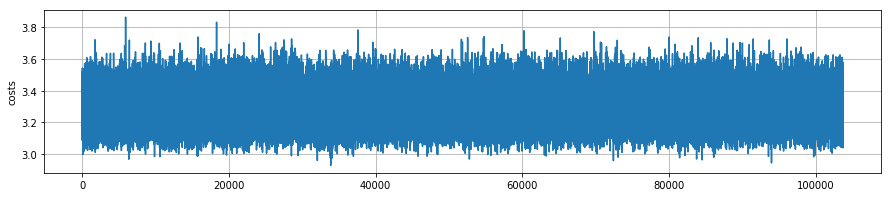

Nearest to <sos>: ,, jptt, from, 跟, 覺得, on, !, my, 把, 如題,
Nearest to 我: 你, 他, 她, 妳, 小弟, 大家, 我們, .我, 這我, 自己,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 亞洲, 美國, 大陸, 產業, 好萊塢,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 單位, 交往, 公司, 發展性, 研究所, 應徵,
Nearest to 喜歡: 討厭, 愛, 超愛, 適合, 最愛, 熱愛, 愛看, 覺得, 推薦, 想要,
Nearest to 可以: 能, 可, 要, 能夠, 會, 還能, 不能, 願意, ok, 只能,
Nearest to 約: 猜, 円, 搭訕, 還錢, 南希, 表妹, 單獨, 約會, 交, 炫耀,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 漫畫, 小說, 國片, 演員,
Nearest to 時間: 上菜, 星期一, 空虛, 樂透, 忙, 撐過去, 中天, 阿波, 龍貓, 怪人,
Nearest to 滿足: 開說, 小於, 嘞, 早點, 自律, 樂意, 呼叫, 溫暖, 幽默, 獲得,
Nearest to 閃光: 男友, 女友, 現任, 新車, 前女友, 射完, 女朋友, 合理化, 倫理, 她,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xdd, xddd, ,,

epoch49
Iteration  10363  ( 10.0 %) Train mean loss:  3.2868118  ( std:  0.102911316 ) ; run time:  30 [s]
Iteration  20741  ( 20.0 %) Train mean loss:  3.2877424  ( std:  0.1029523 ) ; run time:  60 [s]
Iteration  31111  ( 30.0 %) Train mean loss:  3.2881835  ( std:  0.1028767 ) ; run time:  91 [s]
Iteration  41478  ( 40.0 %) Train mea

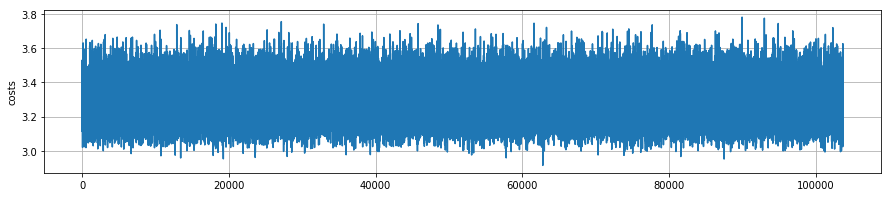

Nearest to <sos>: ,, jptt, from, 跟, 覺得, on, !, my, 如題, 把,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 自己, 我們, 本魯, 這我,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 亞洲, 美國, 大陸, 產業, 可恥,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 交往, 單位, 公司, 應徵, 研究所, 發展性,
Nearest to 喜歡: 討厭, 愛, 超愛, 適合, 最愛, 熱愛, 愛看, 覺得, 推薦, 習慣,
Nearest to 可以: 能, 可, 要, 能夠, 還能, 會, 不能, 願意, ok, 只能,
Nearest to 約: 猜, 搭訕, 円, 還錢, 南希, 表妹, 單獨, 約會, 交, 炫耀,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 漫畫, 小說, 演員, 國片,
Nearest to 時間: 上菜, 星期一, 空虛, 樂透, 忙, 撐過去, 中天, 阿波, 看錢, 龍貓,
Nearest to 滿足: 開說, 小於, 嘞, 早點, 自律, 樂意, 呼叫, 溫暖, 感觸, 享受,
Nearest to 閃光: 男友, 女友, 現任, 新車, 前女友, 射完, 她, 女朋友, 合理化, 倫理,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xdd, xddd, posted,

epoch50
Iteration  10357  ( 10.0 %) Train mean loss:  3.2854886  ( std:  0.10308143 ) ; run time:  30 [s]
Iteration  20731  ( 20.0 %) Train mean loss:  3.286359  ( std:  0.10290054 ) ; run time:  60 [s]
Iteration  31098  ( 30.0 %) Train mean loss:  3.2867463  ( std:  0.102931745 ) ; run time:  91 [s]
Iteration  41474  ( 40.0 %) Trai

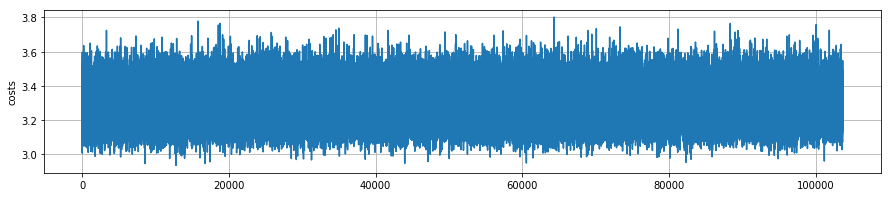

Nearest to <sos>: ,, jptt, from, 跟, 覺得, !, on, my, 如題, 把,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 自己, 我們, 這我, .我,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 亞洲, 美國, 大陸, 可恥, 產業,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 單位, 公司, 交往, 發展性, 傳產, 應徵,
Nearest to 喜歡: 討厭, 愛, 超愛, 適合, 最愛, 愛看, 熱愛, 覺得, 習慣, 推薦,
Nearest to 可以: 能, 可, 要, 能夠, 會, 還能, 不能, ok, 願意, 只能,
Nearest to 約: 猜, 円, 搭訕, 還錢, 南希, 表妹, 單獨, 約會, 炫耀, 交,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 漫畫, 小說, 發行, 國片,
Nearest to 時間: 上菜, 星期一, 空虛, 樂透, 忙, 撐過去, 中天, 阿波, 龍貓, 看錢,
Nearest to 滿足: 開說, 小於, 嘞, 早點, 自律, 樂意, 溫暖, 呼叫, 感觸, 獲得,
Nearest to 閃光: 男友, 女友, 現任, 新車, 前女友, 射完, 她, 女朋友, 合理化, 倫理,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, posted, xddd, xdd,

epoch51
Iteration  10373  ( 10.0 %) Train mean loss:  3.2829823  ( std:  0.10417001 ) ; run time:  30 [s]
Iteration  20749  ( 20.0 %) Train mean loss:  3.2845292  ( std:  0.10346417 ) ; run time:  60 [s]
Iteration  31116  ( 30.0 %) Train mean loss:  3.2847822  ( std:  0.103239655 ) ; run time:  91 [s]
Iteration  41484  ( 40.0 %) Trai

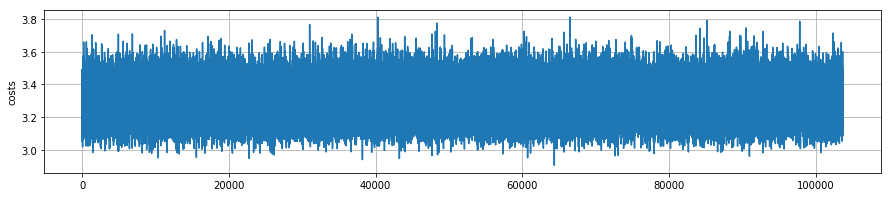

Nearest to <sos>: ,, jptt, from, 跟, 覺得, !, on, my, 如題, 把,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 自己, 我們, 這我, .我,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 亞洲, 美國, 大陸, 可恥, 好萊塢,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 單位, 公司, 研究所, 發展性, 打工, 交往,
Nearest to 喜歡: 討厭, 愛, 超愛, 適合, 最愛, 熱愛, 愛看, 覺得, 習慣, 推薦,
Nearest to 可以: 能, 可, 要, 能夠, 還能, 會, 不能, 只能, ok, 願意,
Nearest to 約: 猜, 搭訕, 円, 南希, 還錢, 表妹, 約會, 單獨, 炫耀, 交,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 國片, 演員, 漫畫, 小說,
Nearest to 時間: 上菜, 空虛, 星期一, 忙, 樂透, 撐過去, 中天, 阿波, 龍貓, 看錢,
Nearest to 滿足: 開說, 小於, 嘞, 早點, 自律, 呼叫, 樂意, 溫暖, 感觸, 內射,
Nearest to 閃光: 男友, 女友, 現任, 新車, 前女友, 射完, 她, 女朋友, 倫理, 合理化,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xdd, xddd, posted,

epoch52
Iteration  10368  ( 10.0 %) Train mean loss:  3.2827423  ( std:  0.10217303 ) ; run time:  30 [s]
Iteration  20727  ( 20.0 %) Train mean loss:  3.2832282  ( std:  0.1023145 ) ; run time:  61 [s]
Iteration  31103  ( 30.0 %) Train mean loss:  3.2840042  ( std:  0.10242662 ) ; run time:  91 [s]
Iteration  41475  ( 40.0 %) Trai

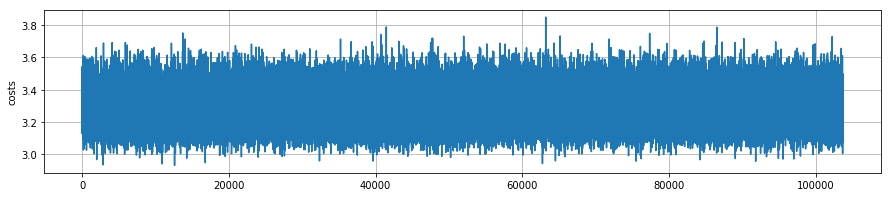

Nearest to <sos>: ,, jptt, from, 跟, 覺得, on, !, 如題, 把, my,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 我們, 自己, 這我, 本魯,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 亞洲, 美國, 大陸, 可恥, 好萊塢,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 單位, 發展性, 交往, 研究所, 公司, 應徵,
Nearest to 喜歡: 討厭, 愛, 超愛, 適合, 最愛, 熱愛, 愛看, 覺得, 習慣, 想要,
Nearest to 可以: 能, 可, 要, 能夠, 還能, 會, 不能, ok, 願意, 只能,
Nearest to 約: 猜, 搭訕, 円, 南希, 還錢, 表妹, 約會, 交, 單獨, 炫耀,
Nearest to 電影: 片, 動畫, 片子, 一部, 作品, 這部, 國片, 小說, 漫畫, 演員,
Nearest to 時間: 上菜, 星期一, 空虛, 忙, 樂透, 撐過去, 中天, 阿波, 看錢, 龍貓,
Nearest to 滿足: 開說, 小於, 嘞, 早點, 自律, 溫暖, 樂意, 呼叫, 內射, 感觸,
Nearest to 閃光: 男友, 女友, 現任, 新車, 前女友, 射完, 她, 女朋友, 倫理, 合理化,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xddd, xdd, posted,

epoch53
Iteration  10369  ( 10.0 %) Train mean loss:  3.2815967  ( std:  0.102626525 ) ; run time:  30 [s]
Iteration  20737  ( 20.0 %) Train mean loss:  3.282237  ( std:  0.10241581 ) ; run time:  61 [s]
Iteration  31101  ( 30.0 %) Train mean loss:  3.2827003  ( std:  0.102872856 ) ; run time:  92 [s]
Iteration  41471  ( 40.0 %) Tr

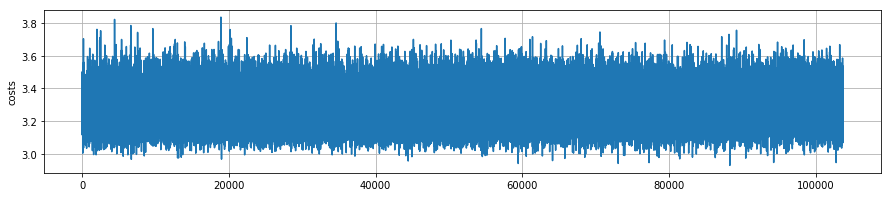

Nearest to <sos>: ,, jptt, from, 跟, 覺得, !, 把, on, my, 如題,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 自己, 本魯, 我們, 這我,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 亞洲, 美國, 大陸, 可恥, 好萊塢,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 單位, 發展性, 交往, 研究所, 打工, 應徵,
Nearest to 喜歡: 討厭, 愛, 超愛, 適合, 最愛, 熱愛, 愛看, 覺得, 習慣, 推薦,
Nearest to 可以: 能, 可, 要, 能夠, 還能, 會, 不能, ok, 願意, 只能,
Nearest to 約: 猜, 搭訕, 円, 南希, 還錢, 表妹, 約會, 交, 炫耀, 單獨,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 漫畫, 國片, 演員, 小說,
Nearest to 時間: 上菜, 星期一, 空虛, 樂透, 忙, 撐過去, 中天, 阿波, 看錢, 家務事,
Nearest to 滿足: 開說, 嘞, 小於, 早點, 自律, 呼叫, 內射, 溫暖, 樂意, 感觸,
Nearest to 閃光: 男友, 女友, 現任, 前女友, 新車, 射完, 女朋友, 她, 倫理, 合理化,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xdd, xddd, posted,

epoch54
Iteration  10374  ( 10.0 %) Train mean loss:  3.2801216  ( std:  0.102015704 ) ; run time:  30 [s]
Iteration  20738  ( 20.0 %) Train mean loss:  3.281026  ( std:  0.10215215 ) ; run time:  60 [s]
Iteration  31104  ( 30.0 %) Train mean loss:  3.2821844  ( std:  0.10190419 ) ; run time:  91 [s]
Iteration  41475  ( 40.0 %) Tr

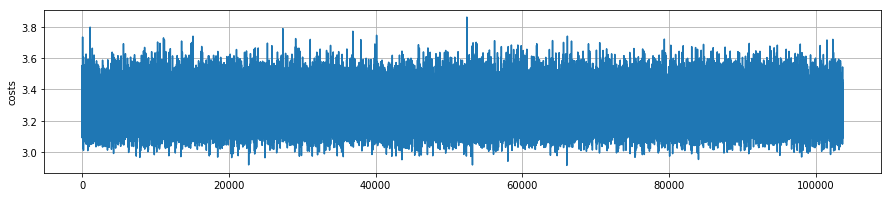

Nearest to <sos>: ,, jptt, from, 跟, !, on, 覺得, my, 把, 如題,
Nearest to 我: 你, 他, 她, 妳, 小弟, 大家, 我們, 這我, 本魯, 自己,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 亞洲, 美國, 大陸, 可恥, 好萊塢,
Nearest to 工作: 上班, 薪水, 發展, 單位, 矽品, 發展性, 研究所, 打工, 應徵, 傳產,
Nearest to 喜歡: 討厭, 愛, 超愛, 適合, 最愛, 熱愛, 愛看, 覺得, 習慣, 想要,
Nearest to 可以: 能, 可, 要, 能夠, 還能, 會, 不能, ok, 願意, 只能,
Nearest to 約: 猜, 搭訕, 円, 南希, 表妹, 約會, 還錢, 單獨, 炫耀, 交,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 這部, 漫畫, 商業片, 國片, 演員,
Nearest to 時間: 上菜, 星期一, 空虛, 樂透, 忙, 撐過去, 中天, 阿波, 龍貓, 看錢,
Nearest to 滿足: 開說, 嘞, 小於, 早點, 自律, 呼叫, 射, 內射, 樂意, 互打,
Nearest to 閃光: 男友, 女友, 現任, 前女友, 新車, 射完, 女朋友, 倫理, 合理化, 朋友,
Nearest to <eos>: xd, sent, ?, !, 嗎, 誤, from, xdd, xddd, posted,

epoch55
Iteration  10368  ( 10.0 %) Train mean loss:  3.2791905  ( std:  0.10197055 ) ; run time:  30 [s]
Iteration  20750  ( 20.0 %) Train mean loss:  3.2808328  ( std:  0.10244627 ) ; run time:  60 [s]
Iteration  31120  ( 30.0 %) Train mean loss:  3.281027  ( std:  0.1025214 ) ; run time:  91 [s]
Iteration  41493  ( 40.0 %) Trai

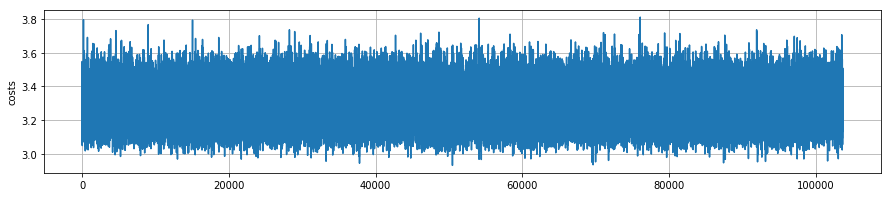

Nearest to <sos>: ,, jptt, from, 跟, !, on, 覺得, my, 如題, 把,
Nearest to 我: 你, 他, 她, 妳, 小弟, 大家, 這我, 自己, 本魯, 我們,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 亞洲, 美國, 大陸, 可恥, 好萊塢,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 單位, 發展性, 研究所, 應徵, 傳產, 打工,
Nearest to 喜歡: 討厭, 愛, 適合, 超愛, 最愛, 熱愛, 愛看, 覺得, 習慣, 推薦,
Nearest to 可以: 能, 可, 要, 能夠, 會, 還能, 不能, 願意, ok, 只能,
Nearest to 約: 猜, 搭訕, 南希, 約會, 円, 表妹, 還錢, 炫耀, 單獨, 交,
Nearest to 電影: 片, 動畫, 片子, 一部, 作品, 這部, 商業片, 漫畫, 小說, 國片,
Nearest to 時間: 上菜, 星期一, 空虛, 撐過去, 樂透, 忙, 中天, 阿波, 龍貓, 看錢,
Nearest to 滿足: 開說, 嘞, 小於, 早點, 自律, 呼叫, 互打, 射, 內射, 外翻,
Nearest to 閃光: 男友, 女友, 現任, 前女友, 新車, 射完, 女朋友, 倫理, 合理化, 朋友,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xddd, posted, xdd,

epoch56
Iteration  10371  ( 10.0 %) Train mean loss:  3.2774704  ( std:  0.10221862 ) ; run time:  30 [s]
Iteration  20747  ( 20.0 %) Train mean loss:  3.278974  ( std:  0.102053724 ) ; run time:  60 [s]
Iteration  31120  ( 30.0 %) Train mean loss:  3.279423  ( std:  0.10200852 ) ; run time:  91 [s]
Iteration  41497  ( 40.0 %) Tra

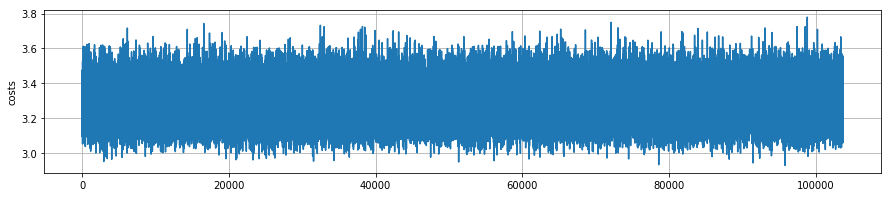

Nearest to <sos>: ,, jptt, from, 跟, !, 覺得, on, 如題, my, 把,
Nearest to 我: 你, 他, 她, 妳, 小弟, 大家, 這我, 自己, 我們, .我,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, 亞洲, yahoo, 美國, 大陸, 可恥, 產業,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 發展性, 單位, 應徵, 研究所, 傳產, 打工,
Nearest to 喜歡: 討厭, 愛, 適合, 最愛, 超愛, 熱愛, 愛看, 覺得, 習慣, 想要,
Nearest to 可以: 能, 可, 要, 能夠, 會, 還能, 不能, 願意, ok, 只能,
Nearest to 約: 猜, 搭訕, 円, 南希, 約會, 表妹, 還錢, 炫耀, 單獨, 交,
Nearest to 電影: 片, 動畫, 片子, 一部, 作品, 這部, 商業片, 國片, 小說, 漫畫,
Nearest to 時間: 上菜, 星期一, 空虛, 樂透, 撐過去, 忙, 中天, 阿波, 看錢, 龍貓,
Nearest to 滿足: 開說, 嘞, 小於, 早點, 自律, 互打, 內射, 呼叫, 外翻, 射,
Nearest to 閃光: 男友, 女友, 現任, 前女友, 新車, 射完, 女朋友, 她, 倫理, 合理化,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xddd, posted, xdd,

epoch57
Iteration  10375  ( 10.0 %) Train mean loss:  3.2763968  ( std:  0.10212461 ) ; run time:  30 [s]
Iteration  20740  ( 20.0 %) Train mean loss:  3.276971  ( std:  0.10203847 ) ; run time:  61 [s]
Iteration  31110  ( 30.0 %) Train mean loss:  3.27781  ( std:  0.10202874 ) ; run time:  91 [s]
Iteration  41476  ( 40.0 %) Train m

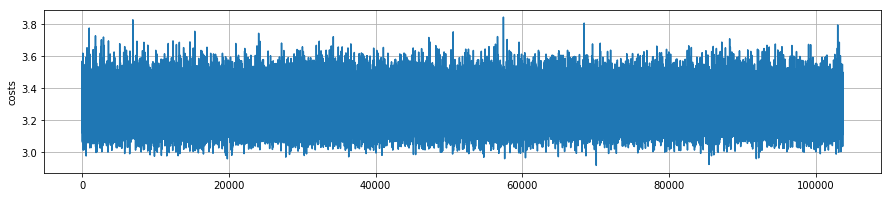

Nearest to <sos>: ,, jptt, from, 跟, !, on, my, 覺得, 如題, 把,
Nearest to 我: 他, 你, 她, 妳, 小弟, 大家, 這我, .我, 本魯, 我們,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 亞洲, 美國, 大陸, 可恥, 產業,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 發展性, 單位, 研究所, 應徵, 打工, 傳產,
Nearest to 喜歡: 討厭, 愛, 超愛, 最愛, 適合, 熱愛, 愛看, 覺得, 習慣, 推薦,
Nearest to 可以: 能, 可, 能夠, 要, 會, 還能, 不能, 願意, ok, 只能,
Nearest to 約: 猜, 搭訕, 南希, 円, 還錢, 表妹, 約會, 炫耀, 交, 單獨,
Nearest to 電影: 片, 動畫, 片子, 一部, 作品, 這部, 國片, 商業片, 小說, 漫畫,
Nearest to 時間: 上菜, 星期一, 空虛, 撐過去, 樂透, 忙, 中天, 阿波, 看錢, 龍貓,
Nearest to 滿足: 開說, 嘞, 小於, 早點, 自律, 互打, 外翻, 呼叫, 感觸, 內射,
Nearest to 閃光: 男友, 女友, 現任, 前女友, 新車, 女朋友, 射完, 倫理, 合理化, 朋友,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, posted, xdd, ,,

epoch58
Iteration  10369  ( 10.0 %) Train mean loss:  3.275844  ( std:  0.10192167 ) ; run time:  33 [s]
Iteration  20733  ( 20.0 %) Train mean loss:  3.27582  ( std:  0.10188518 ) ; run time:  63 [s]
Iteration  31106  ( 30.0 %) Train mean loss:  3.276704  ( std:  0.101520136 ) ; run time:  93 [s]
Iteration  41480  ( 40.0 %) Train me

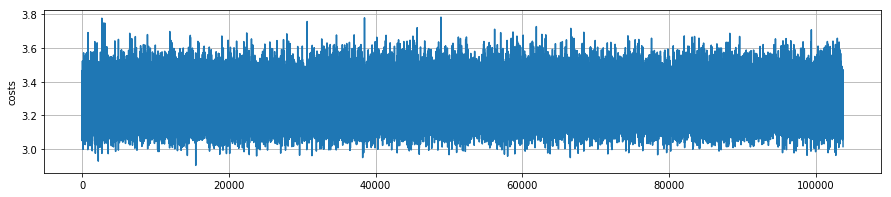

Nearest to <sos>: ,, jptt, from, 跟, !, 覺得, on, 如題, my, 把,
Nearest to 我: 你, 他, 她, 妳, 小弟, 大家, .我, 本魯, 自己, 這我,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 亞洲, 美國, 大陸, 可恥, 好萊塢,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 發展性, 應徵, 單位, 研究所, 打工, 行業,
Nearest to 喜歡: 討厭, 愛, 超愛, 最愛, 適合, 愛看, 熱愛, 覺得, 習慣, 推薦,
Nearest to 可以: 能, 可, 要, 能夠, 還能, 會, 不能, ok, 願意, 只能,
Nearest to 約: 猜, 搭訕, 南希, 表妹, 還錢, 円, 約會, 交, 單獨, 炫耀,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 商業片, 這部, 國片, 演員, 小說,
Nearest to 時間: 上菜, 星期一, 空虛, 樂透, 撐過去, 忙, 中天, 看錢, 阿波, 龍貓,
Nearest to 滿足: 開說, 嘞, 小於, 早點, 自律, 互打, 外翻, 內射, 感觸, 呼叫,
Nearest to 閃光: 男友, 女友, 現任, 前女友, 新車, 女朋友, 射完, 倫理, 合理化, 朋友,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, xddd, posted, xdd,

epoch59
Iteration  10359  ( 10.0 %) Train mean loss:  3.2748547  ( std:  0.101392046 ) ; run time:  30 [s]
Iteration  20723  ( 20.0 %) Train mean loss:  3.2760696  ( std:  0.10113586 ) ; run time:  60 [s]
Iteration  31100  ( 30.0 %) Train mean loss:  3.2769268  ( std:  0.10127258 ) ; run time:  91 [s]
Iteration  41473  ( 40.0 %) 

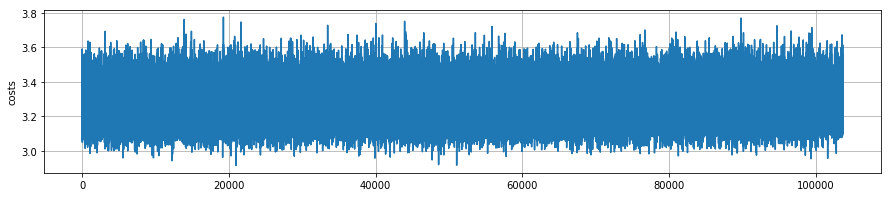

Nearest to <sos>: ,, jptt, from, 跟, !, on, 把, 如題, 覺得, my,
Nearest to 我: 你, 他, 她, 妳, 小弟, 大家, 這我, 我們, 本魯, .我,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, yahoo, 亞洲, 美國, 大陸, 可恥, 產業,
Nearest to 工作: 上班, 薪水, 發展, 矽品, 發展性, 單位, 打工, 研究所, 傳產, 應徵,
Nearest to 喜歡: 討厭, 愛, 最愛, 適合, 超愛, 熱愛, 愛看, 覺得, 習慣, 推薦,
Nearest to 可以: 能, 可, 能夠, 要, 還能, 會, 不能, ok, 願意, 只能,
Nearest to 約: 猜, 搭訕, 南希, 表妹, 還錢, 円, 炫耀, 單獨, 約會, 交,
Nearest to 電影: 片, 動畫, 一部, 片子, 作品, 商業片, 這部, 國片, 小說, 漫畫,
Nearest to 時間: 上菜, 星期一, 空虛, 樂透, 撐過去, 忙, 阿波, 看錢, 中天, 龍貓,
Nearest to 滿足: 開說, 嘞, 小於, 早點, 自律, 互打, 外翻, 內射, 射, 呼叫,
Nearest to 閃光: 男友, 女友, 現任, 前女友, 新車, 她, 女朋友, 射完, 倫理, 合理化,
Nearest to <eos>: xd, sent, ?, !, 嗎, 誤, from, posted, xddd, xdd,

epoch60
Iteration  10377  ( 10.0 %) Train mean loss:  3.27474  ( std:  0.10076835 ) ; run time:  30 [s]
Iteration  20745  ( 20.0 %) Train mean loss:  3.2742412  ( std:  0.102267206 ) ; run time:  60 [s]
Iteration  31120  ( 30.0 %) Train mean loss:  3.2750986  ( std:  0.10221591 ) ; run time:  90 [s]
Iteration  41486  ( 40.0 %) Train

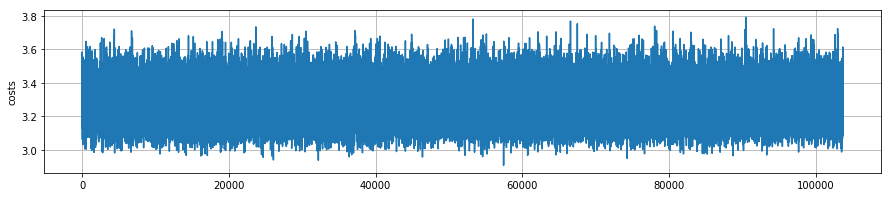

Nearest to <sos>: ,, jptt, from, 跟, !, on, 覺得, my, 如題, 把,
Nearest to 我: 你, 他, 她, 妳, 小弟, .我, 大家, 本魯, 這我, 人,
Nearest to 台灣: 臺灣, 日本, 中國, 韓國, 亞洲, yahoo, 美國, 大陸, 可恥, 產業,
Nearest to 工作: 薪水, 上班, 發展, 發展性, 矽品, 單位, 研究所, 行業, 打工, 應徵,
Nearest to 喜歡: 討厭, 愛, 超愛, 最愛, 適合, 熱愛, 愛看, 覺得, 習慣, 欣賞,
Nearest to 可以: 能, 可, 要, 能夠, 會, 還能, 不能, 願意, ok, 只能,
Nearest to 約: 猜, 搭訕, 表妹, 還錢, 炫耀, 南希, 円, 約會, 單獨, 砍,
Nearest to 電影: 片, 動畫, 片子, 一部, 作品, 商業片, 這部, 國片, 小說, 漫畫,
Nearest to 時間: 星期一, 上菜, 空虛, 忙, 樂透, 撐過去, 阿波, 看錢, 中天, 龍貓,
Nearest to 滿足: 開說, 嘞, 早點, 小於, 自律, 互打, 外翻, 內射, 感觸, 射,
Nearest to 閃光: 男友, 女友, 現任, 前女友, 新車, 她, 女朋友, 倫理, 射完, 合理化,
Nearest to <eos>: xd, sent, !, ?, 嗎, 誤, from, posted, xdd, xddd,

Elapsed time in total: 18508


In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
################################################################
# Set parameter
################################################################
build_new_model = True

patience = 0
num_epoch = 60
batch_size = 128
embedding_size = 300 # Dimension of the embedding vector.
w2v_lr = 1.0
exp_decay_rate = 0.8
vocab_size = len(vocab)
num_instances = sum_content_size
iter_per_epoch = num_instances // batch_size

exp_decay_steps = sum_content_size // batch_size
similar_nn_num = 10 # number of nearest neighbors

valid_examples = [vocab[SOS_id],vocab['我'],vocab['台灣'],vocab['工作'],
                   vocab['喜歡'],vocab['可以'],vocab['約'],vocab['電影'],
                   vocab['時間'],vocab['滿足'],vocab['閃光'],vocab[EOS_id]]
number_sampled = 10 # Number of negative examples to sample.

################################################################
# Build Embedding model
################################################################
def word2vector_model():
    train_inputs = tf.placeholder(tf.int32, shape=[None], name='train_inputs')
    train_labels = tf.placeholder(tf.int32, shape=[None, None], name='train_labels')
    
    # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([vocab_size+1, embedding_size], -1.0, 1.0),
                             name='embeddings')
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    # Construct the variables for the softmax
    nce_weights = tf.Variable(tf.truncated_normal([vocab_size+1, embedding_size],
                                                  stddev=1.0 / np.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocab_size+1]))
    
    # Compute the NCE loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_true=skip_window*2,
                                         num_sampled=number_sampled,
                                         num_classes=vocab_size+1),
                         name='nce_cost')
    # We use the SGD optimizer.
    global_step = tf.Variable(0, trainable=False)
    dynam_w2v_lr = tf.train.exponential_decay(w2v_lr, global_step, exp_decay_steps, 
                                                           exp_decay_rate, staircase=False)
    global_step = global_step + 1
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=dynam_w2v_lr).minimize(loss, 
                                                name='optimizer')
    return train_inputs, train_labels, loss, optimizer, embeddings
    
################################################################
# Prepare to run session
################################################################
total_start_t = time.time()
if build_new_model:
    str_epoch = 0
    model_name = 'PTT_Words_Embedding_' + str(total_start_t)
else:
    str_epoch = 50
    model_name = 'PTT_Words_Embedding_1523412734.9787965'
    mdl_dir = os.path.join(base_dir, 'model')
    if not os.path.exists(mdl_dir):
        os.makedirs(mdl_dir)
    model_dir = os.path.join(mdl_dir, model_name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

iter_pct = num_instances // 10
if (num_instances % batch_size) > 0:
    iter_per_epoch += 1
costs_list = []

best_costs_mean = 0.0
early_stop_counter = 0

################################################################
# Run model session
################################################################
word2vector_graph = tf.Graph()
if build_new_model:
    ######## Build model parameters ########
    with word2vector_graph.as_default():
        train_inputs, train_labels, cost, optimizer, embeddings = word2vector_model()

with tf.Session(graph=word2vector_graph) as sess:
    if build_new_model:
        sess.run(tf.global_variables_initializer())
        best_epoch = 1
    else:
        ######## Load model parameters ########
        # Load model and weight parameters
        best_epoch = str_epoch
        load_model_dir = os.path.join(model_dir, 'model-{}'.format(str_epoch))
        loader = tf.train.import_meta_graph(load_model_dir + '.meta')
        loader.restore(sess, load_model_dir)
        # Load named input parameters
        train_inputs = word2vector_graph.get_tensor_by_name('train_inputs:0')
        train_labels = word2vector_graph.get_tensor_by_name('train_labels:0')
        loss = word2vector_graph.get_tensor_by_name('nce_cost')
        optimizer = word2vector_graph.get_operation_by_name('optimizer')
        
    ######## Run model epoch ########
    for e in range(str_epoch,str_epoch+num_epoch):
        rand_idxs = np.random.permutation(num_instances)
        print('\n========')
        print('epoch' + str(e+1))
        print('========')
        start_t = time.time()
        costs = []
        
        ######## Get random input batch and training model. ########
        batch_counts = 0
        iter_count = 0
        X_batch = []
        Y_batch = []
        for i in range(num_instances):
            rand_input = total_inputs[rand_idxs[i]]
            rand_label = total_labels[rand_idxs[i],:]
            vocab_rand = np.random.uniform(0.0, 1.0)
            if vocab_rand < vocab_rate[rand_input]:
                #if 0 in rand_label:
                    #np.delete(rand_label, np.argwhere(0 == rand_label))
                X_batch.append(rand_input)
                Y_batch.append(rand_label)
                batch_counts = (batch_counts + 1) % batch_size
                
                if batch_counts % batch_size == 0:
                    iter_count += 1
                    X_batch = np.array(X_batch)
                    Y_batch = np.array(Y_batch)
                    optimizer_op, loss = sess.run( [optimizer, cost],
                                        {train_inputs: X_batch, train_labels: Y_batch})
                    X_batch = []
                    Y_batch = []
                    if np.isnan(loss):
                        print('\n!!!! Loss is NaN! !!!!')
                        print('NaN epoch: ', e, ' ; NaN iteration: ', iter_count)
                        print('The last loss: ', last_loss)
                        print('Optimizer: ', optimizer_op)
                        print('The last optimizer: ', last_optimizer_op)
                        break
                    else:
                        costs.append(loss)
                        last_loss = loss
                        last_optimizer_op = optimizer_op
            
            if (i+1) % iter_pct == 0:
                costs_pct10 = np.array(costs[-iter_pct:])
                print('Iteration ',iter_count,' (',round((i+1)*100/num_instances,2),'%) Train mean loss: ',
                      costs_pct10.mean(), ' ( std: ', costs_pct10.std(), 
                      ') ; run time: ', int(time.time() - start_t), '[s]')
            '''elif i == 0:
                print('Iteration ',iter_count,' (',round((i+1)*100/num_instances,2),'%) Train mean loss: ',
                      loss, '; run time: ', int(time.time() - start_t), '[s]')'''
        
        ######## Save model weight parameters and information. ########
        costs_mean = np.array(costs).mean()
        if costs_mean < best_costs_mean or e == 0:
            best_costs_mean = costs_mean
            best_epoch = e
            early_stop_counter = 0
            print('Save best score!! ', best_costs_mean)
        else:
            early_stop_counter += 1
            print('Count early stop!! ', early_stop_counter)

        print('Elapsed time in epoch ', e+1, ': ', int(time.time() - start_t), 
              ' [s]: iteration number: ', iter_count)
        
        if e==0:
            mdl_dir = os.path.join(base_dir, 'model')
            if not os.path.exists(mdl_dir):
                os.makedirs(mdl_dir)
            model_dir = os.path.join(mdl_dir, model_name)
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)

        model_path = os.path.join(model_dir, 'model-%d' %(e+1))
        saver = tf.train.Saver()
        saver.save(sess, model_path)
        
        ######## Print cost curve of this epoch. ########
        costs_list.append(costs)
        plt.figure(figsize=(15,3))
        plt.plot(costs)
        plt.ylabel('costs')
        plt.grid()
        plt.show()
        
        ######## Generate title form testing content and validating model. ########
        embeddings_epoch = embeddings.eval()
        norm = np.sqrt(np.sum(np.square(embeddings_epoch), 1, keepdims=True))
        normalized_embeddings = embeddings_epoch / norm
        valid_embeddings = np.array([normalized_embeddings[valid] for valid in valid_examples])
        similarity = np.matmul(valid_embeddings, np.transpose(normalized_embeddings))
        
        for i, example  in enumerate(valid_examples):
            nearest = (-similarity[i, :]).argsort()[1:similar_nn_num+1]
            log = 'Nearest to %s:' % vocab_reverse[example]
            for k in range(similar_nn_num):
                close_word = vocab_reverse[nearest[k]]
                log = '%s %s,' % (log, close_word)
            print(log)
        
        if patience != 0 and early_stop_counter >= patience:
            print('\n#######')
            print('Best model')
            print('#######')
            print('Stop by early stopping')
            print('Best score: ', best_costs_mean, 'Beat model: ', best_epoch)
            break

print('\nElapsed time in total: ' + str(int(time.time() - total_start_t)))

INFO:tensorflow:Restoring parameters from E:/Raw data/PTT\model\PTT_Words_Embedding_1526955724.200002\model-60


C:\Users\User\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['msjh'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


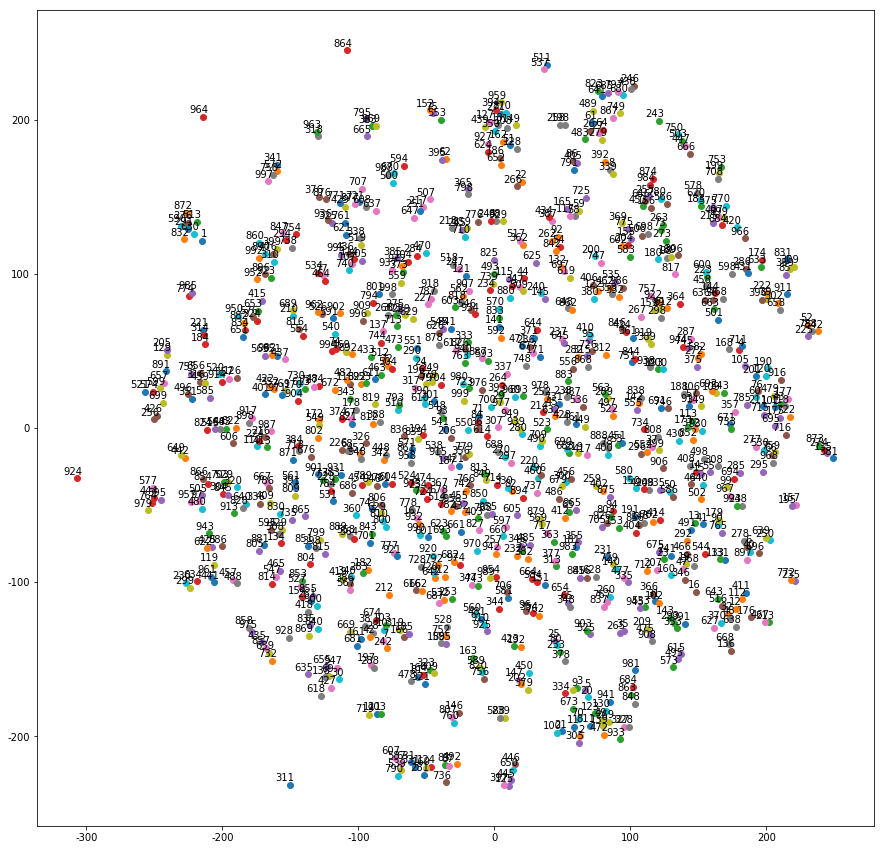

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
################################################################
# Load Embedding model
################################################################

str_epoch = 60
model_name = 'PTT_Words_Embedding_1526955724.200002'
mdl_dir = os.path.join(base_dir, 'model')
if not os.path.exists(mdl_dir):
    os.makedirs(mdl_dir)
model_dir = os.path.join(mdl_dir, model_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

word2vector_graph = tf.Graph()
with tf.Session(graph=word2vector_graph) as sess:
    ######## Load model parameters ########
    # Load model and weight parameters
    load_model_dir = os.path.join(model_dir, 'model-{}'.format(str_epoch))
    loader = tf.train.import_meta_graph(load_model_dir + '.meta')
    loader.restore(sess, load_model_dir)
    # Load named input parameters
    embeddings = word2vector_graph.get_tensor_by_name('embeddings:0').eval()
    norm = np.sqrt(np.sum(np.square(embeddings), 1, keepdims=True))
    normal_embeddings = embeddings / norm
        
'''    with open(os.path.join(totalboard_dir, 'vocab.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab = eval(f_text.read())

    with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'r', encoding='utf-8-sig') as f_text:
        vocab_reverse = eval(f_text.read())'''

from matplotlib.font_manager import FontProperties 
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import pylab
from sklearn.manifold import TSNE
################################################################
# Build t-SNE dimensionality reduction for embeddings lookup.
################################################################

#font = FontProperties(fname= r'C:\windows\fonts\Microsoft JhengHei UI\msjh', size=10)
plt.rcParams['font.family']='msjh'#'Microsoft JhengHei UI' # 指定默認字體
plt.rcParams['axes.unicode_minus'] = False # 解決保存圖像是負號'-'顯示為方塊的問題

num_points = 1000
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=50000, method='exact')
two_d_embeddings = tsne.fit_transform(normal_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

#words = [vocab_reverse[i] for i in range(1, num_points+1)]
words = [i for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [30]:
for i in range(1, num_points+1):
    print(i, vocab_reverse[i])

1 <sos>
2 <eos>
3 .
4 的
5 ,
6 是
7 我
8 了
9 '
10 你
11 ?
12 有
13 就
14 都
15 也
16 不
17 在
18 很
19 會
20 !
21 嗎
22 好
23 要
24 看
25 跟
26 吧
27 啊
28 他
29 說
30 人
31 可以
32 沒
33 覺得
34 去
35 想
36 被
37 真的
38 自己
39 什麼
40 不是
41 就是
42 她
43 但
44 到
45 知道
46 還是
47 不會
48 沒有
49 xd
50 才
51 比較
52 為
53 喜歡
54 這樣
55 又
56 一個
57 應該
58 這
59 那
60 因為
61 啦
62 多
63 對
64 阿
65 不要
66 如果
67 用
68 上
69 女生
70 =
71 讓
72 吃
73 現在
74 做
75 大
76 所以
77 朋友
78 感覺
79 看到
80 和
81 大家
82 推
83 1
84 把
85 怎麼
86 喔
87 +
88 一下
89 很多
90 只是
91 可能
92 這種
93 找
94 再
95 一樣
96 問題
97 公司
98 後
99 還
100 呢
101 不過
102 能
103 妳
104 打
105 的話
106 其實
107 男友
108 太
109 好像
110 電影
111 時候
112 還有
113 一定
114 女友
115 來
116 買
117 這個
118 但是
119 工作
120 然後
121 出來
122 一直
123 @
124 2
125 樓上
126 叫
127 超
128 比
129 po
130 qq
131 只有
132 像
133 只
134 中
135 或
136 有人
137 一起
138 男生
139 xddd
140 不錯
141 完
142 已經
143 不能
144 個
145 開始
146 一
147 這麼
148 直接
149 有點
150 等
151 請
152 小
153 先
154 台灣
155 之前
156 最近
157 根本
158 請問
159 一堆
160 不用
161 對方
162 最
163 時間
164 各位
165 那個
166 他們
167 好看
168 得
169 3
170 